## Step 3: Evaluate expression of the epigenetic memory astrocyte gene signature across cell types in the Allen Brain Cell atlas

Now we'll examine how expression of the epigenetic memory astrocyte signature varies across the cell types in the Allen Brain Cell atlas. 

In [1]:
import os
os.chdir('..') # changing working directory to parent 'EpiMemAstros' directory, adjust as needed
import pandas as pd
from pathlib import Path
import numpy as np
import anndata as ad
from scipy import sparse
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'
sc.set_figure_params(dpi = 600, dpi_save = 600, vector_friendly = True, format = 'svg')

First, read in the ABC atlas anndata object we saved in the previous step. Note that this AnnData file is nearly 300 GB in size. Depending on your hardware specifications, you may need to load this file in 'backed' mode so that it is not fully loaded into memory. [See the Scanpy documentation for details.](https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html)

In [2]:
mouse_atlas = sc.read_h5ad('outputs/allen_brain_cell_atlas-RAW.h5ad')
mouse_atlas

AnnData object with n_obs × n_vars = 4042976 × 32285
    obs: 'cell_barcode_x', 'library_label_x', 'anatomical_division_label', 'cell_barcode_y', 'barcoded_cell_sample_label', 'library_label_y', 'feature_matrix_label', 'entity', 'brain_section_label', 'library_method', 'region_of_interest_acronym', 'donor_label', 'donor_genotype', 'donor_sex', 'dataset_label', 'x', 'y', 'cluster_alias', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'name', 'mapped_ncbi_identifier', 'comment'

This large atlas includes clusters defined at highly granular levels. Because we're interested in expression across general cell type categories, we'll next assign cells into broad cell type categories based on their cluster labels.

We'll first examine the broadest cluster classes present in the dataset.

In [3]:
classes = np.unique(mouse_atlas.obs['class'].values)
classes

array(['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
       '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa',
       '22 MB-HB Sero', '23 P Glut', '24 MY Glut', '25 Pineal Glut',
       '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',
       '30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular',
       '34 Immune'], dtype=object)

Neuron are divided among many different cluster classes, but for our purposes we group them into a single cell type group. Let's extract a list of the neuronal cluster classes.

In [4]:
neuron_prefixes = [f"{i:02d}" for i in range(1, 30)]
neuron_classes = [x for x in classes if x.startswith(tuple(neuron_prefixes))]
neuron_classes

['01 IT-ET Glut',
 '02 NP-CT-L6b Glut',
 '03 OB-CR Glut',
 '04 DG-IMN Glut',
 '05 OB-IMN GABA',
 '06 CTX-CGE GABA',
 '07 CTX-MGE GABA',
 '08 CNU-MGE GABA',
 '09 CNU-LGE GABA',
 '10 LSX GABA',
 '11 CNU-HYa GABA',
 '12 HY GABA',
 '13 CNU-HYa Glut',
 '14 HY Glut',
 '15 HY Gnrh1 Glut',
 '16 HY MM Glut',
 '17 MH-LH Glut',
 '18 TH Glut',
 '19 MB Glut',
 '20 MB GABA',
 '21 MB Dopa',
 '22 MB-HB Sero',
 '23 P Glut',
 '24 MY Glut',
 '25 Pineal Glut',
 '26 P GABA',
 '27 MY GABA',
 '28 CB GABA',
 '29 CB Glut']

Next we create a cell-level metadata dataframe and add a category called 'celltype', grouping cell classes into broad cell type categories. Then, we'll add this category into the anndata object's cell metadata.

In [5]:
obs_df = mouse_atlas.obs

obs_df['celltype'] = np.where(obs_df['class'].isin(neuron_classes), "Neuron", "")
obs_df['celltype'] = np.where(obs_df['subclass']=='316 Bergmann NN', "Bergmann glia", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass'].isin(['317 Astro-CB NN', '318 Astro-NT NN',
       '319 Astro-TE NN', '320 Astro-OLF NN']), "Astrocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='321 Astroependymal NN', "Astroependymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='322 Tanycyte NN', "Tanycyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='323 Ependymal NN', "Ependymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='324 Hypendymal NN', "Hypendymal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='325 CHOR NN', "Choroid plexus", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='326 OPC NN', "OPC", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='327 Oligo NN', "Oligodendrocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='328 OEC NN', "Olfactory epithelial", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='329 ABC NN', "Arachnoid barrier", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='330 VLMC NN', "Vascular leptomeningeal", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='331 Peri NN', "Pericyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='332 SMC NN', "Smooth muscle", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='333 Endo NN', "Endothelial", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='334 Microglia NN', "Microglia", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='335 BAM NN', "BAM", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='336 Monocytes NN', "Monocyte", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='337 DC NN', "Dendritic cell", obs_df['celltype'])
obs_df['celltype'] = np.where(obs_df['subclass']=='338 Lymphoid NN', "Lymphoid", obs_df['celltype'])

mouse_atlas.obs = obs_df

Let's check the total number of cells present in each broad cell type category.

In [6]:
obs_df.celltype.value_counts()

celltype
Neuron                     2957911
Oligodendrocyte             422574
Astrocyte                   299182
OPC                         122605
Endothelial                  88011
Microglia                    86232
Pericyte                     24907
Smooth muscle                14614
Vascular leptomeningeal       9104
BAM                           5626
Bergmann glia                 3321
Ependymal                     3259
Astroependymal                1232
Olfactory epithelial          1132
Tanycyte                      1072
Arachnoid barrier              857
Choroid plexus                 476
Lymphoid                       404
Dendritic cell                 285
Hypendymal                     139
Monocyte                        33
Name: count, dtype: int64

This atlas includes 4 million cells, the vast majority of which are neurons; however, a few very small clusters are also present (e.g. Monocytes or Hypendymal cells). Because these cell types are only present in extremely small numbers, we will exclude them from our reference object, as the gene expression information we have for these cell types is going to be less reliable. We chose to exclude clusters with fewer than 400 cells, as these each comprise fewer than 0.01% of the dataset. 

In [7]:
mouse_atlas.obs.celltype = mouse_atlas.obs.celltype.astype('category')
min_cells = 400
cluster_key = "celltype"

adatas = [mouse_atlas[mouse_atlas.obs[cluster_key].isin([clust])] for clust in mouse_atlas.obs[cluster_key].cat.categories]

for dat in adatas:
    if dat.n_obs < min_cells:
        sc.pp.subsample(dat, n_obs=0)

mouse_atlas = adatas[0].concatenate(*adatas[1:])

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/655600406.py:11: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  mouse_atlas = adatas[0].concatenate(*adatas[1:])


Because the gene signature lists we have from Lee et al are in gene symbol format, we next swap out gene symbols for the Ensembl IDs previously labeling our anndata object .var slot.

In [8]:
mouse_atlas.var['ensembl_id'] = mouse_atlas.var.index
mouse_atlas.var['gene_symbol'] = mouse_atlas.var['gene_symbol'].astype(str)
mouse_atlas.var['original_gene_symbol'] = mouse_atlas.var.gene_symbol
mouse_atlas.var.index = mouse_atlas.var.gene_symbol
mouse_atlas.var_names_make_unique()

Next, normalize and log-transform the count data.

In [9]:
sc.pp.normalize_total(mouse_atlas, target_sum=10000)
sc.pp.log1p(mouse_atlas)

Now, read in the data from Lee et al's Supplementary Table 3. The authors defined all genes with log2FoldChange > 0 in this table as a part of the epigenetic memory astrocyte 'Up-Signature'. The authors defined all genes with log2FoldChange < 0 in this table as a part of the epigenetic memory astrocyte 'Down-Signature'. 

We next create lists containing the respective signatures.

In [10]:
signature = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_signature = np.sort(signature[(signature.log2FoldChange > 0)].gene.values)
down_signature = np.sort(signature[(signature.log2FoldChange < 0)].gene.values)

Now we run the scanpy function score_genes to calculate an enrichment score for the Up- and Down- signature gene sets for each single cell. This function implements the same scoring method described in [Tirosh et al 2016 (PMID: 27124452)](https://pubmed.ncbi.nlm.nih.gov/27124452/), also used by the [Seurat function AddModuleScore](https://satijalab.org/seurat/reference/addmodulescore), which Lee et al used for scoring their gene signatures in the mouse and human single-cell RNA-seq datasets in Figures 4 & 5. 

In [11]:
sc.tl.score_genes(mouse_atlas, gene_list=up_signature, score_name="Up_Signature")
sc.tl.score_genes(mouse_atlas, gene_list=down_signature, score_name="Down_Signature")

       'Gm15922', 'Gm37347', 'Gm43181', 'Gm45222', 'Gm45551', 'Gm48377',
       'Gm49339', 'Gm5641', 'Gm7536', 'Gm8995', 'Gm9794', 'Gm9973', 'H2az1',
       'Rpl15-ps3', 'Rpl28-ps1', 'Rps12-ps3', 'Rps16-ps2', 'Rps23-ps1',
       'Rps7-ps3', 'Rpsa-ps10', 'Tpt1-ps3', 'Ubb-ps'],
      dtype='object')
       'Gm48309', 'Gm50367', 'Gm5512', 'H2aw', 'Magef1', 'Mtarc2', 'Septin4'],
      dtype='object')


Next, we'll calculate the mean and standard deviation of the Up- and Down- signature enrichment scores within each cell type.

In [12]:
cell_obs = mouse_atlas.obs

means = cell_obs.groupby('celltype')['Up_Signature'].mean()
sorted_names = means.sort_values().index.values
means = means[sorted_names]
stds = cell_obs.groupby('celltype')['Up_Signature'].std()
stds = stds[sorted_names]

dmeans = cell_obs.groupby('celltype')['Down_Signature'].mean()
dmeans = dmeans[sorted_names]
dstds = cell_obs.groupby('celltype')['Down_Signature'].std()
dstds = dstds[sorted_names]

rainbow = ['#721E17',
             '#B3211D',
             '#DD3F26',
             '#E57130',
             '#E59437',
             '#D8AE3E',
             '#B6BC4B',
             '#88BB6B',
             '#68B090',
             '#59A5A8',
             '#4F97BA',
             '#4D7DC5',
             '#5B5FAF',
             '#7C4C9A',
             '#9F69AB',
             '#B894C5',
             '#D2C3E2',
             '#E8ECFB']

means_df = pd.DataFrame({'up':means, 'down':dmeans, 'upstd':stds, 'downstd':dstds, 'color':rainbow})

means_df

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/4135655092.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = cell_obs.groupby('celltype')['Up_Signature'].mean()
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/4135655092.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = cell_obs.groupby('celltype')['Up_Signature'].std()
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/4135655092.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

up      down     upstd   downstd    color
celltype                                                                
Astrocyte                0.008072  0.624501  0.029069  0.057098  #721E17
Bergmann glia            0.023219  0.645255  0.017910  0.036845  #B3211D
OPC                      0.059904  0.340312  0.020564  0.038996  #DD3F26
Astroependymal           0.097892  0.441902  0.038172  0.097978  #E57130
Olfactory epithelial     0.123745  0.285704  0.037508  0.053428  #E59437
Neuron                   0.129823  0.187098  0.028051  0.026597  #D8AE3E
Tanycyte                 0.132797  0.256811  0.039973  0.052592  #B6BC4B
Oligodendrocyte          0.136148  0.163427  0.021533  0.031370  #88BB6B
Ependymal                0.144729  0.154695  0.025913  0.042899  #68B090
Pericyte                 0.181802  0.084461  0.031692  0.030122  #59A5A8
Vascular leptomeningeal  0.227021  0.131586  0.052299  0.030229  #4F97BA
Endothelial              0.296665  0.060412  0.048585  0.026982  #4D7DC5
Smooth muscle            0.303528  0.034950  0.056314  0.030498  #5B5FAF
Microglia                0.330731  0.030651  0.053133  0.025026  #7C4C9A
Arachnoid barrier        0.332817  0.086637  0.043923  0.022180  #9F69AB
Lymphoid                 0.338076 -0.003843  0.048937  0.027922  #B894C5
BAM                      0.349169  0.028379  0.055426  0.025885  #D2C3E2
Choroid plexus           0.352814  0.058713  0.026096  0.021727  #E8ECFB

Plot those values in a scatter plot: 

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/1729775931.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/1729775931.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.5)


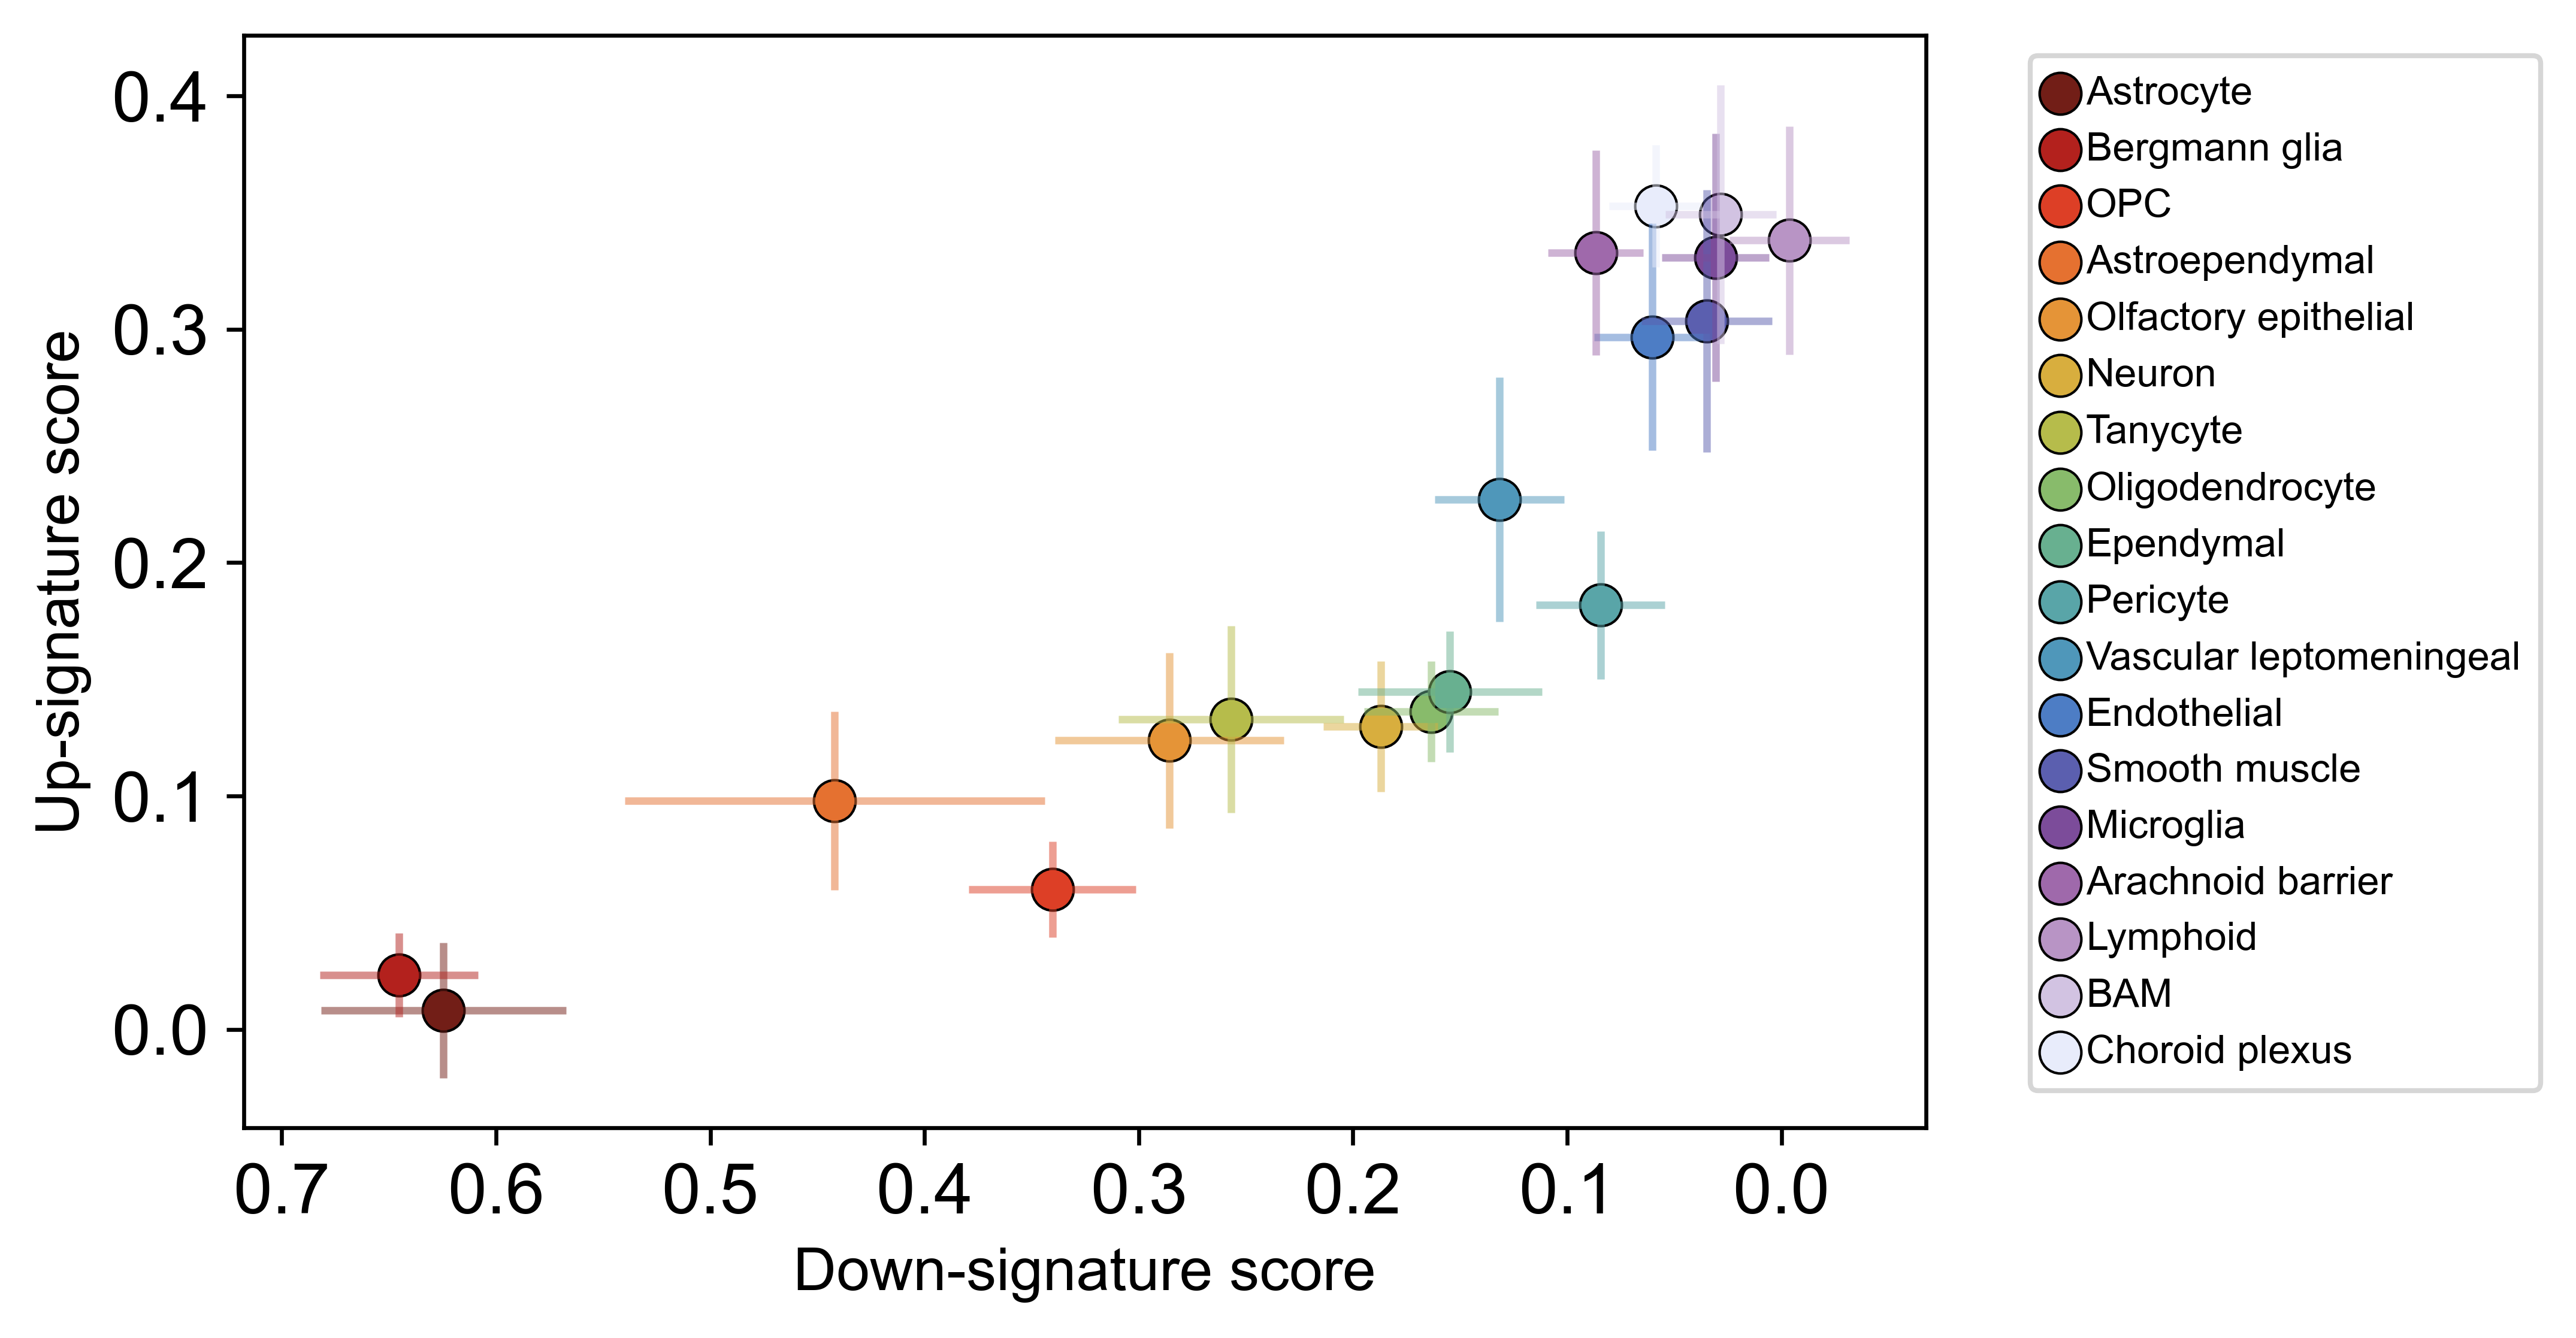

In [13]:
with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi":300}):
    fig, ax = plt.subplots()
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, markerscale=1, borderpad=0.5)
    
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.5)

    ax.invert_xaxis()
    plt.grid(False)
    plt.xlabel('Down-signature score', fontsize=12)
    plt.ylabel('Up-signature score', fontsize=12)
    
    plt.savefig('outputs/figures/figure1c.svg', format='svg', bbox_inches = 'tight')

Create a matching color palette for violin plots:

In [14]:
color_pal = dict(zip(sorted_names, rainbow))

Now we evalute the distribution of enrichment scores across the cell type groups.

First for the Up-Signature: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


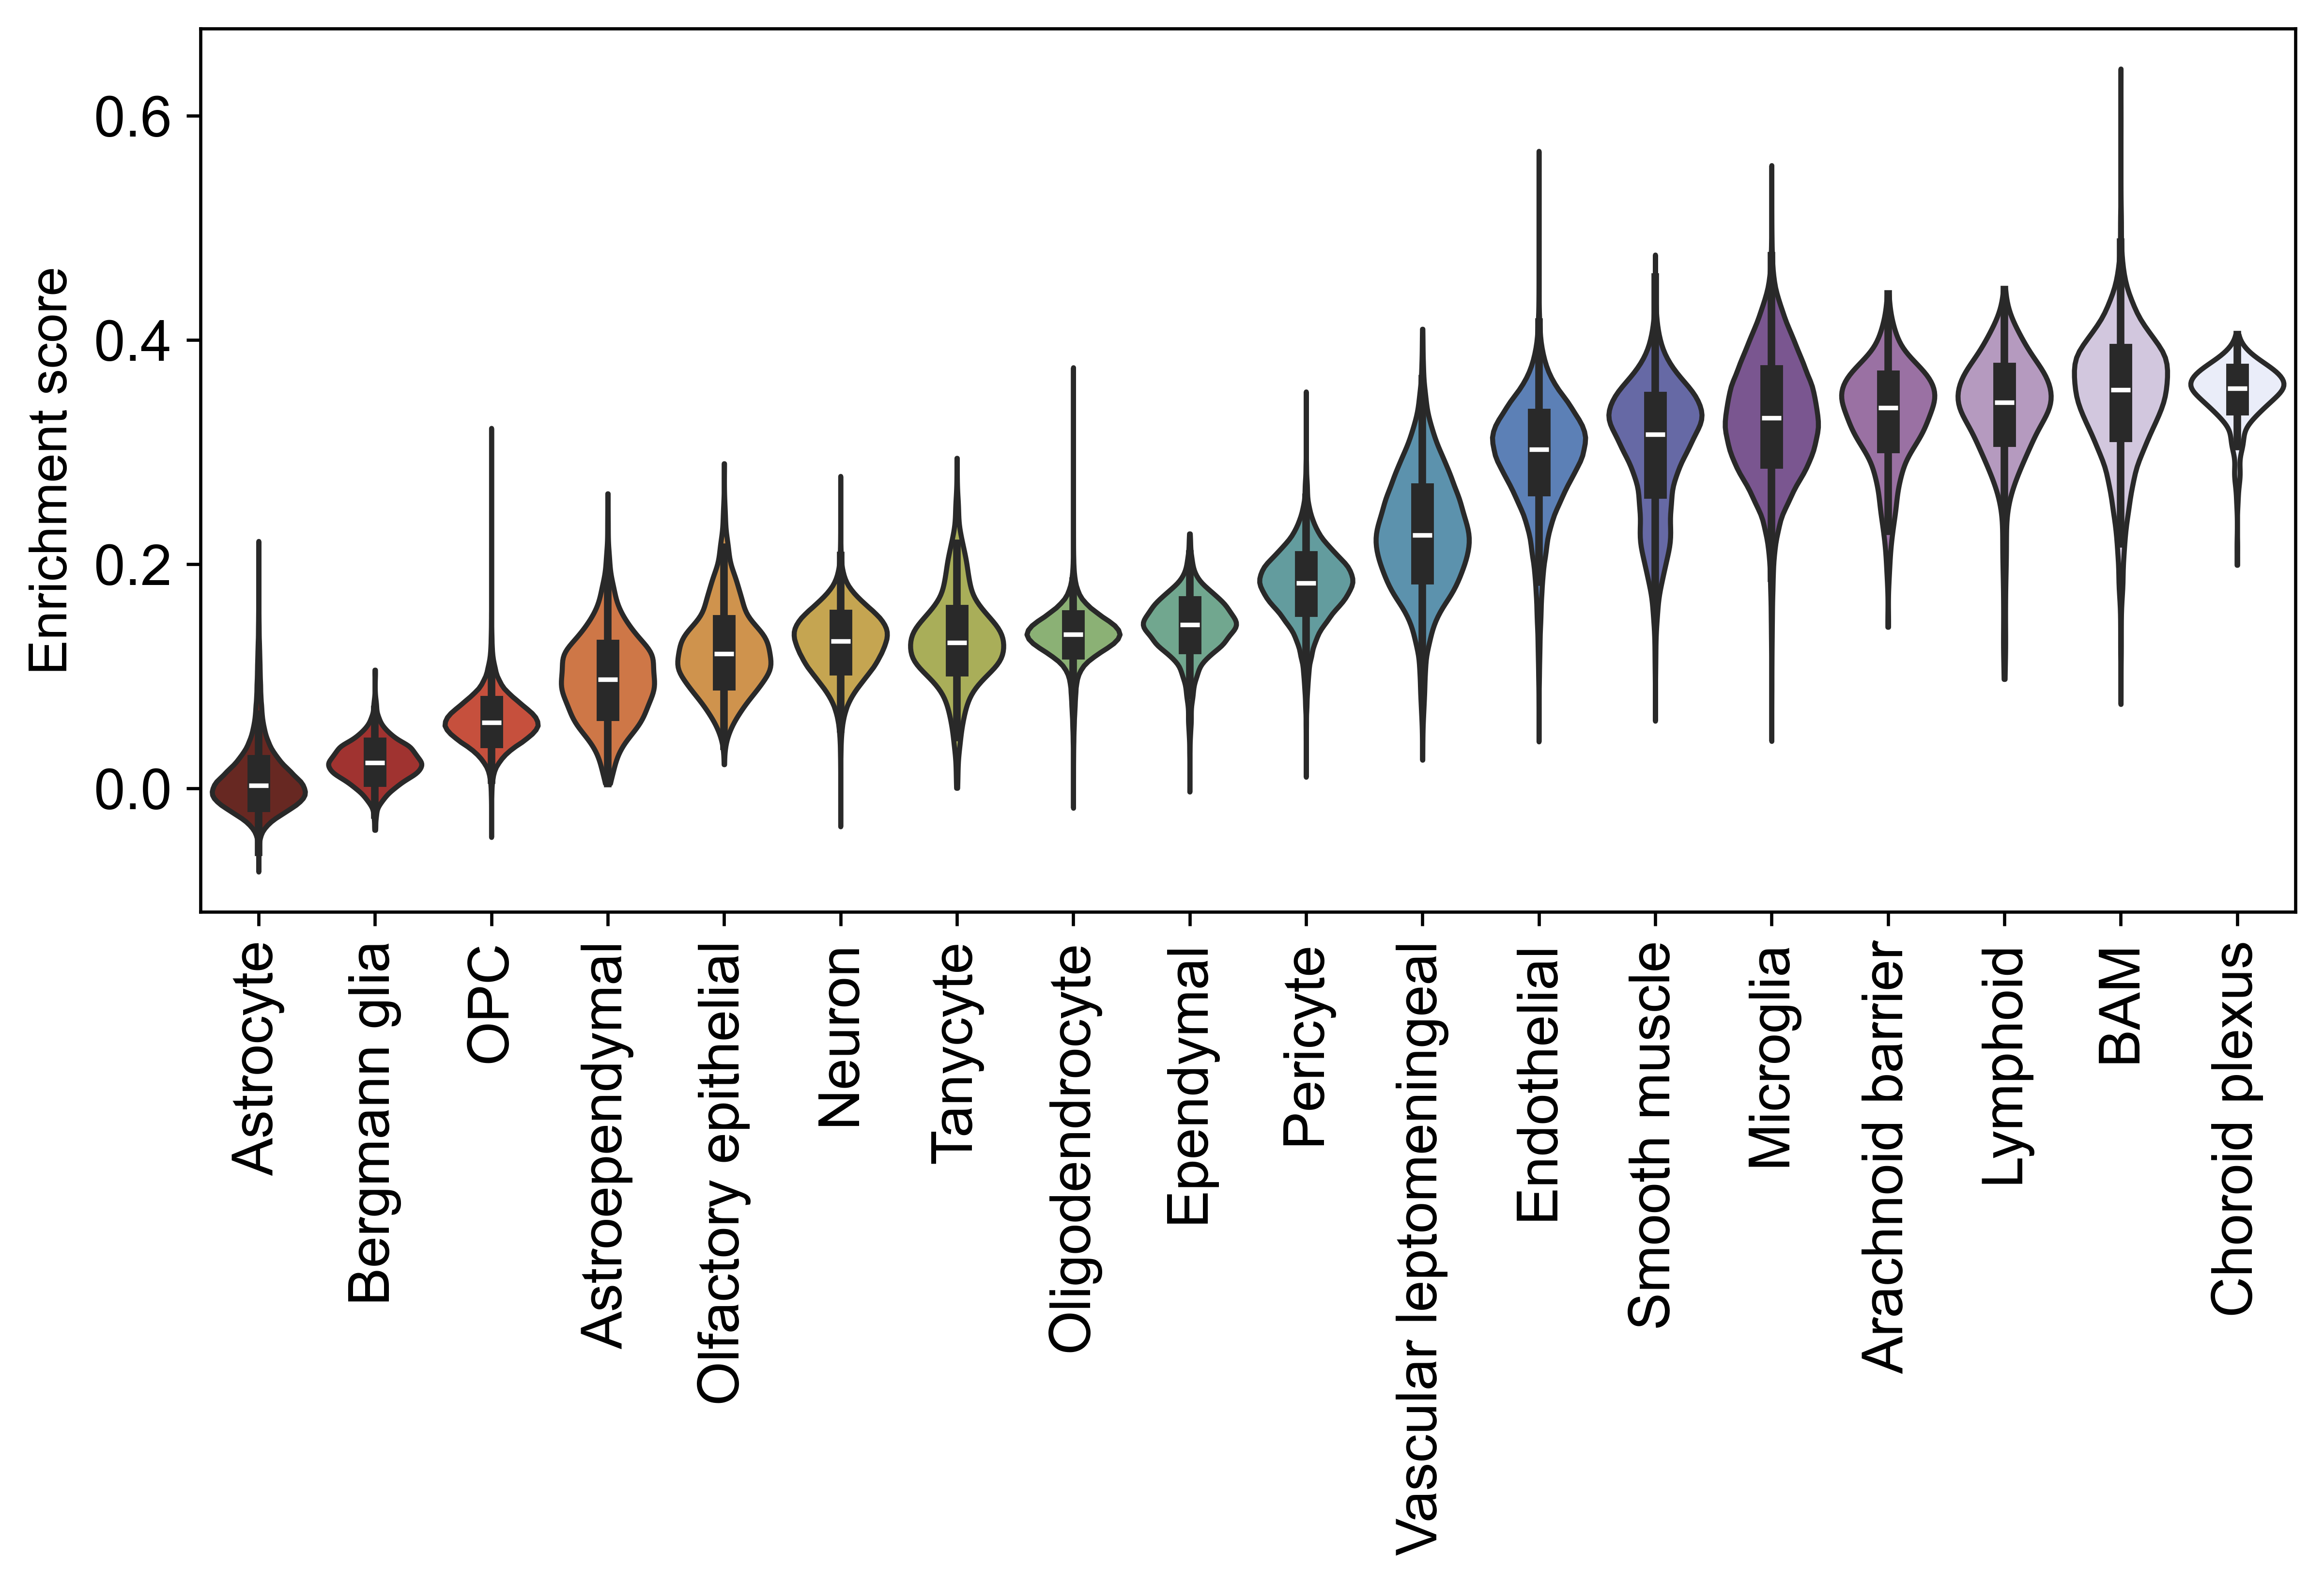

In [15]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Up_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = ['Astrocyte', 'Bergmann glia', 'OPC', 'Astroependymal', 'Olfactory epithelial', 'Neuron', 'Tanycyte', 'Oligodendrocyte', 'Ependymal', 'Pericyte', 'Vascular leptomeningeal', 
                        'Endothelial', 'Smooth muscle', 'Microglia', 'Arachnoid barrier', 'Lymphoid', 'BAM', 'Choroid plexus'],
                palette = color_pal, show=False)
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1b_upsignature.svg', format='svg', bbox_inches = 'tight')

And for the Down-Signature:

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


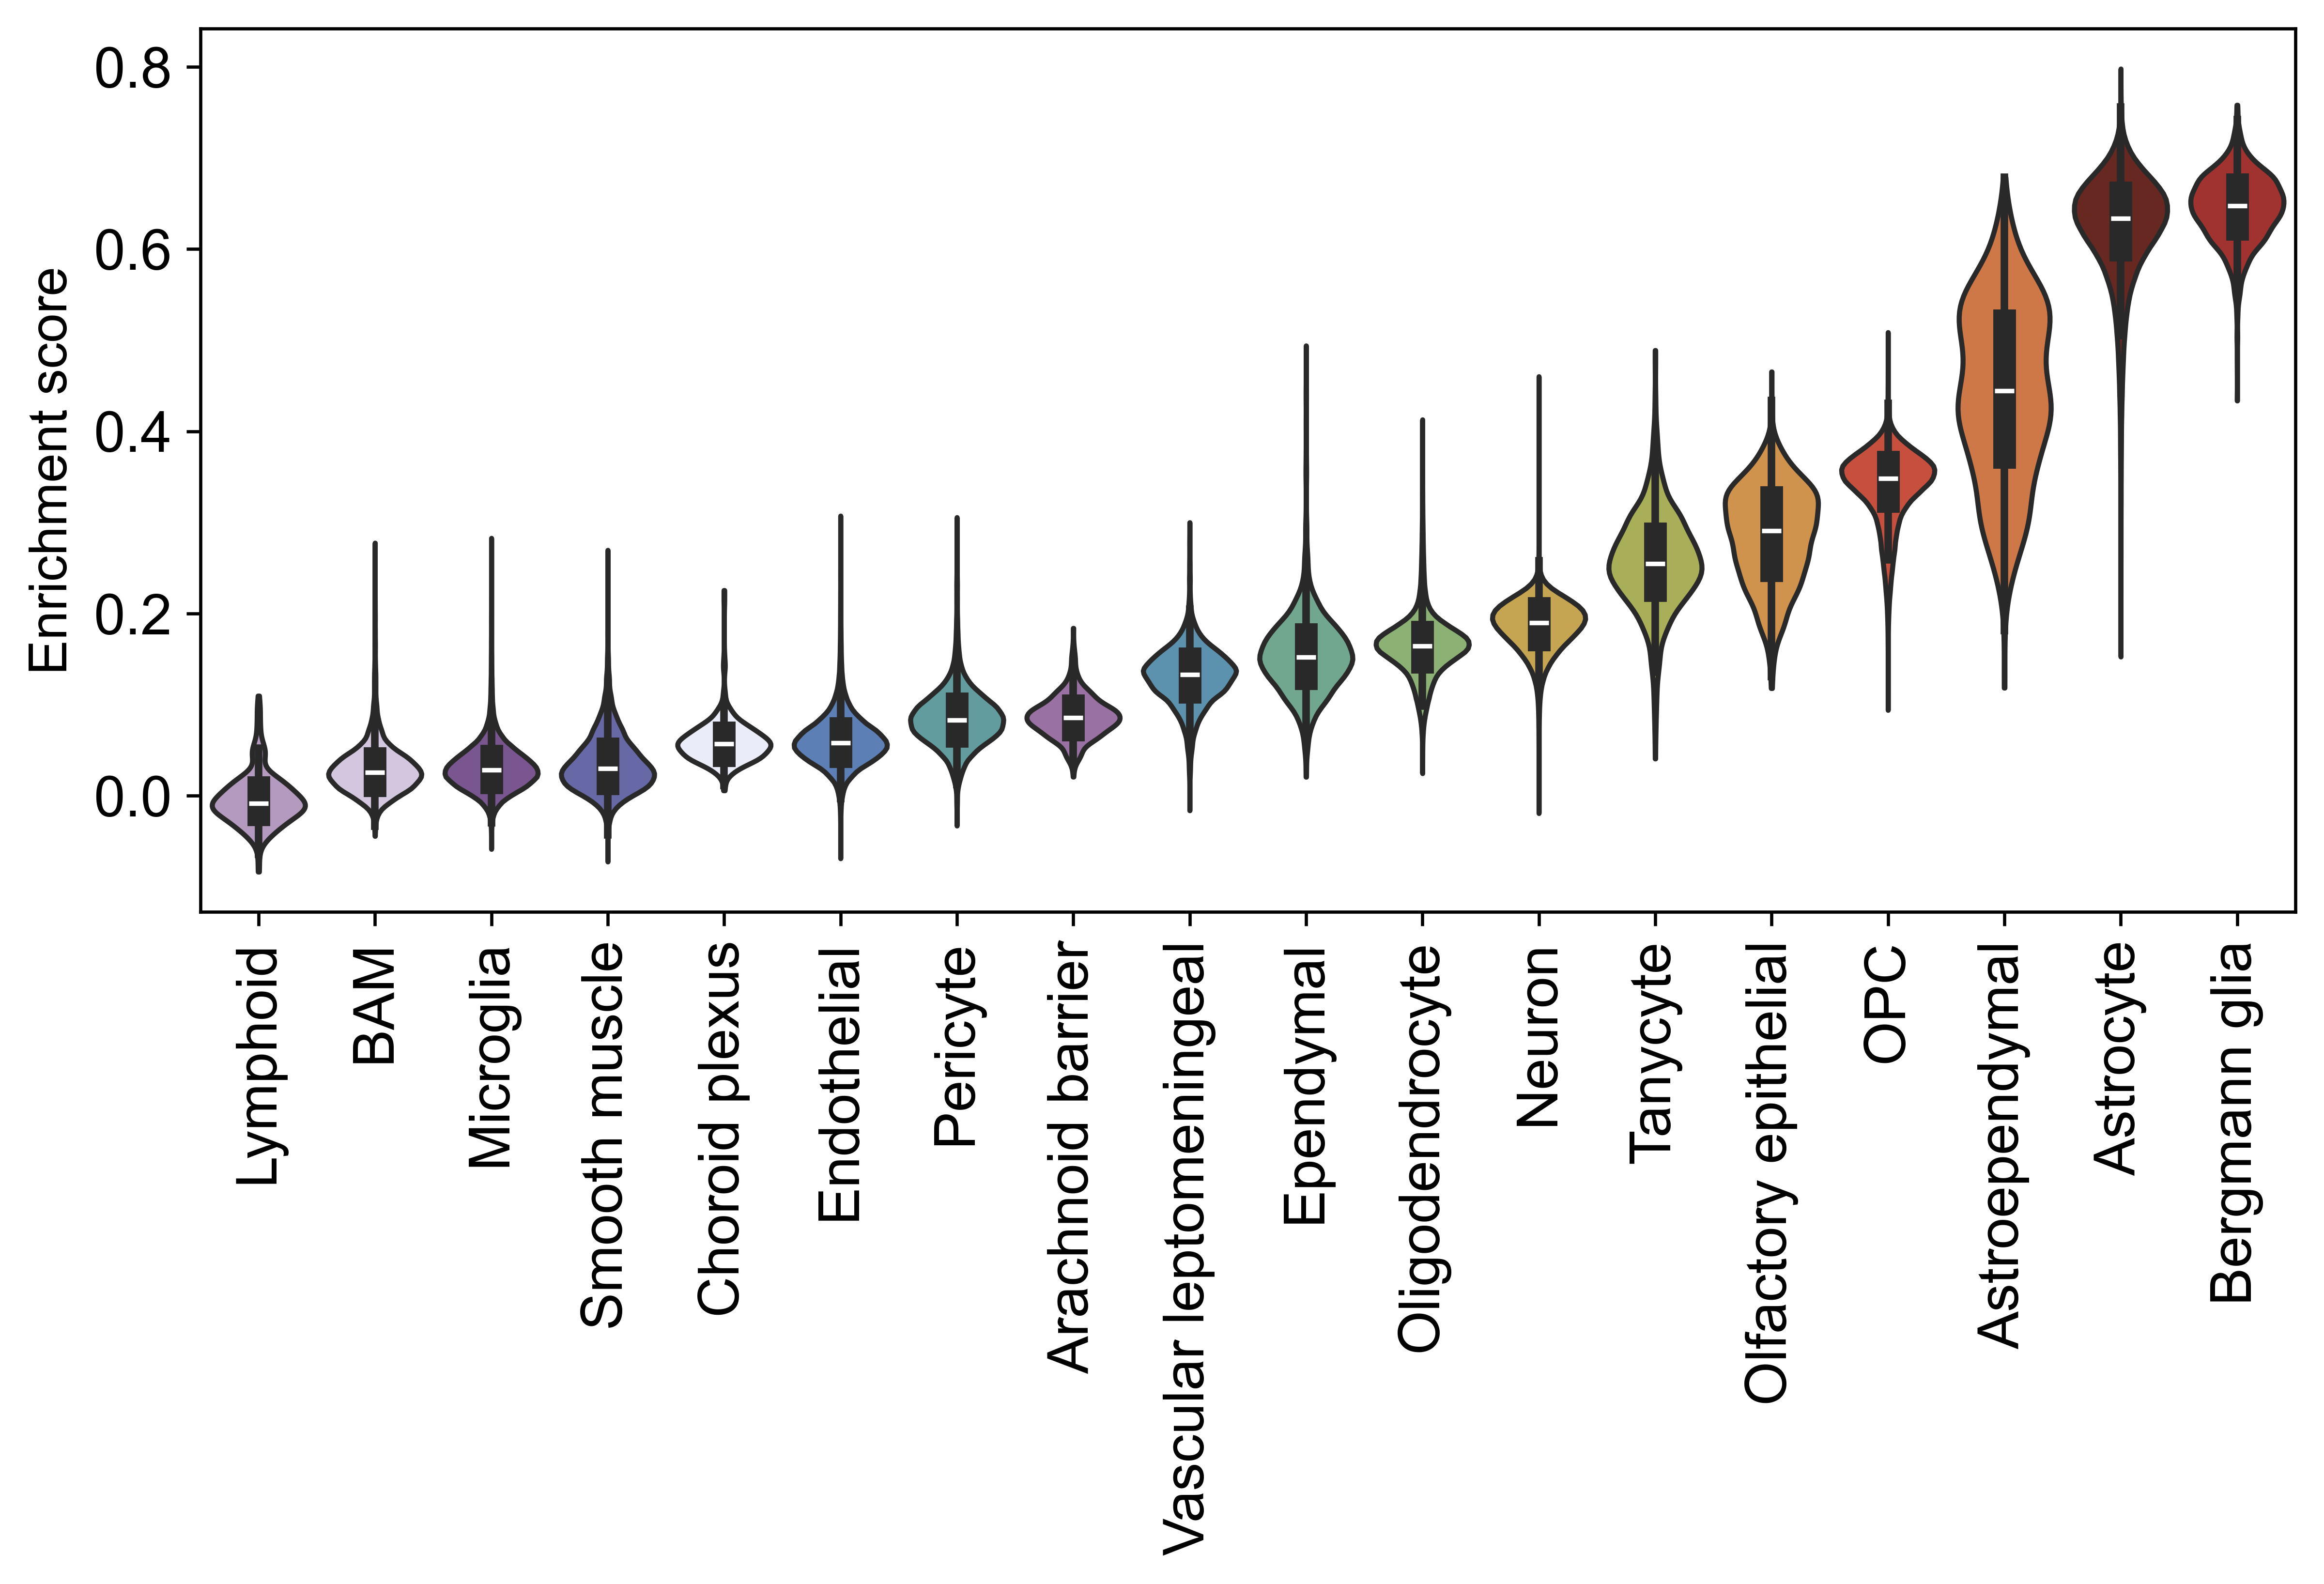

In [16]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Down_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box',
                order = ['Lymphoid', 'BAM', 'Microglia', 'Smooth muscle', 'Choroid plexus', 'Endothelial', 'Pericyte', 'Arachnoid barrier', 'Vascular leptomeningeal', 
                         'Ependymal', 'Oligodendrocyte', 'Neuron', 'Tanycyte', 'Olfactory epithelial', 'OPC', 'Astroependymal', 'Astrocyte', 'Bergmann glia'],
                palette = color_pal, show=False)
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/figure1b_downsignature.svg', format='svg', bbox_inches = 'tight')

The Up- and Down-Signature gene sets include many genes which were not statistically significant in differential expression between the two-hit & one-hit cytokine stimulation groups. We discuss the derivation of the gene signatures in more detail in the Step 5 notebook.

Let's evaluate whether the enrichment scores differ if we remove all genes which were non-signficant (adjusted p-value > 0.05):

In [17]:
sig_up_signature = np.sort(signature[(signature.log2FoldChange > 0) & (signature.padj < 0.05)].gene.values)
sig_down_signature = np.sort(signature[(signature.log2FoldChange < 0) & (signature.padj < 0.05)].gene.values)

sc.tl.score_genes(mouse_atlas, gene_list=sig_up_signature, score_name="Sig_Up_Signature")
sc.tl.score_genes(mouse_atlas, gene_list=sig_down_signature, score_name="Sig_Down_Signature")

       'Ubb-ps'],
      dtype='object')


For the Up-Signature, this doesn't much change the pattern of enrichment scores across cell types: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


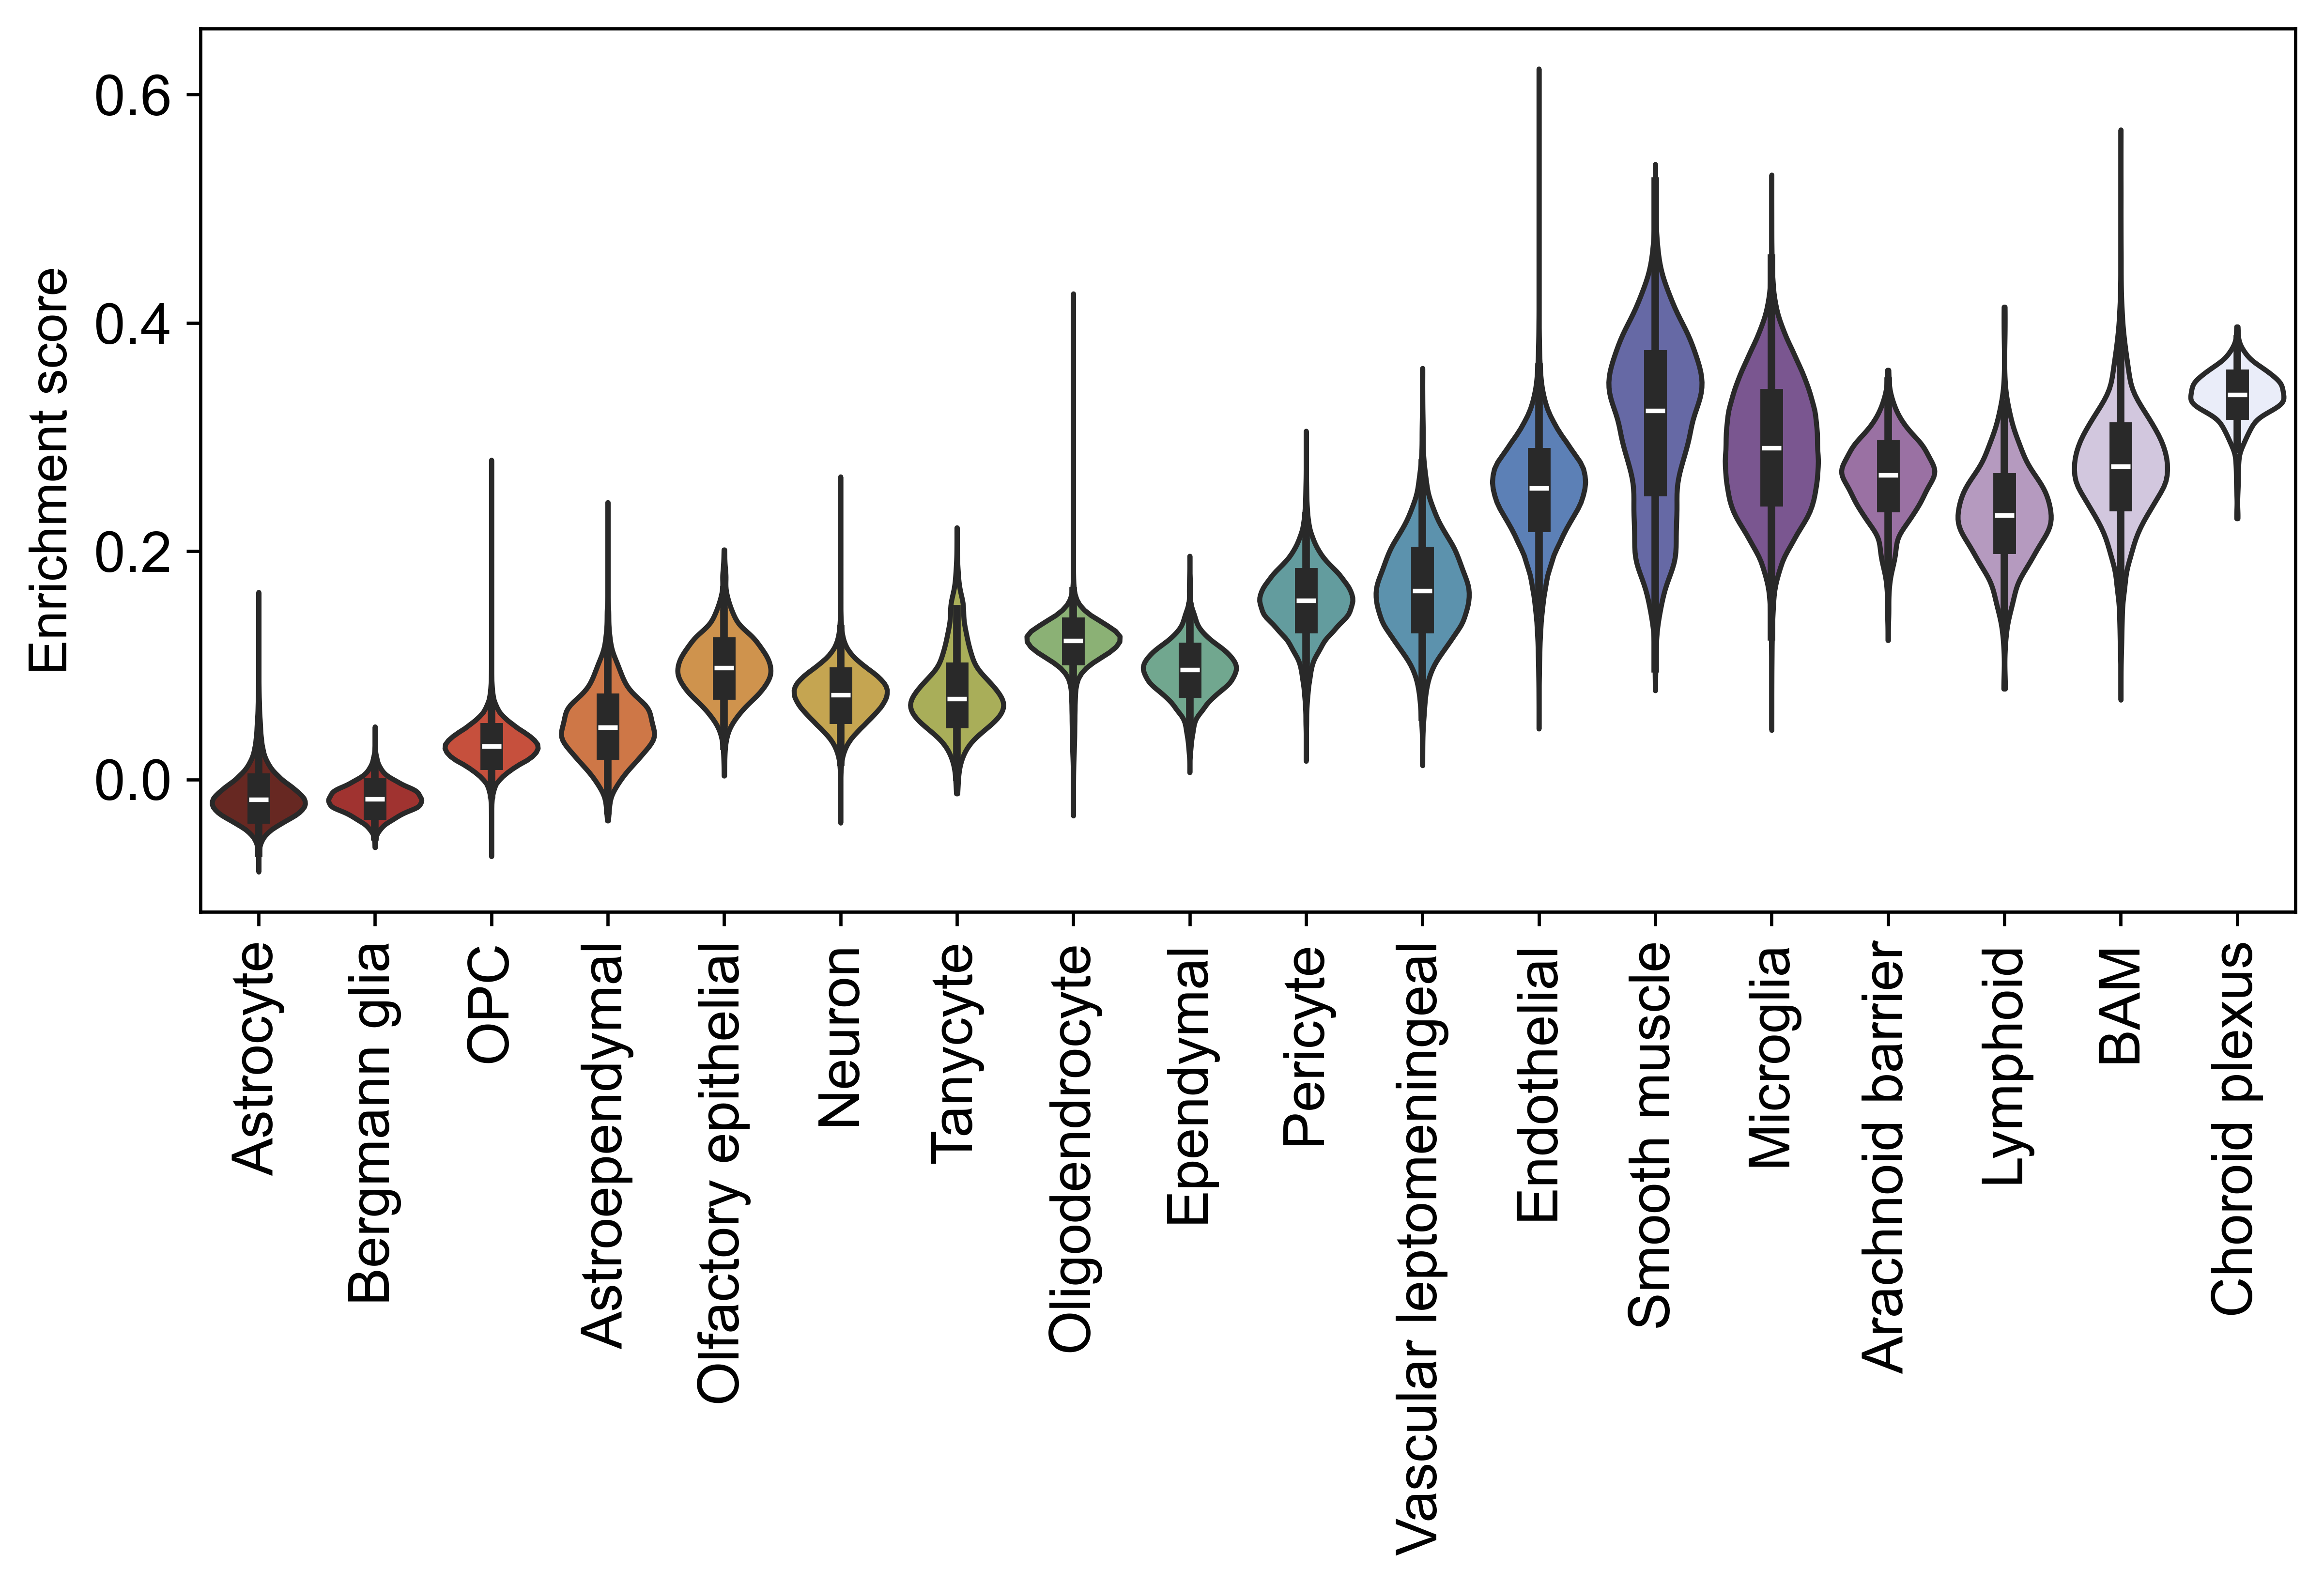

In [18]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    ax = sc.pl.violin(mouse_atlas, keys=['Sig_Up_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = ['Astrocyte', 'Bergmann glia', 'OPC', 'Astroependymal', 'Olfactory epithelial', 'Neuron', 'Tanycyte', 'Oligodendrocyte', 'Ependymal', 'Pericyte', 'Vascular leptomeningeal', 
                        'Endothelial', 'Smooth muscle', 'Microglia', 'Arachnoid barrier', 'Lymphoid', 'BAM', 'Choroid plexus'],
                palette = color_pal, show=False)
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/supplementaryfigure1a_upsignature.svg', format='svg', bbox_inches = 'tight')

This seems to hold true for the Down-Signature as well: 

/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


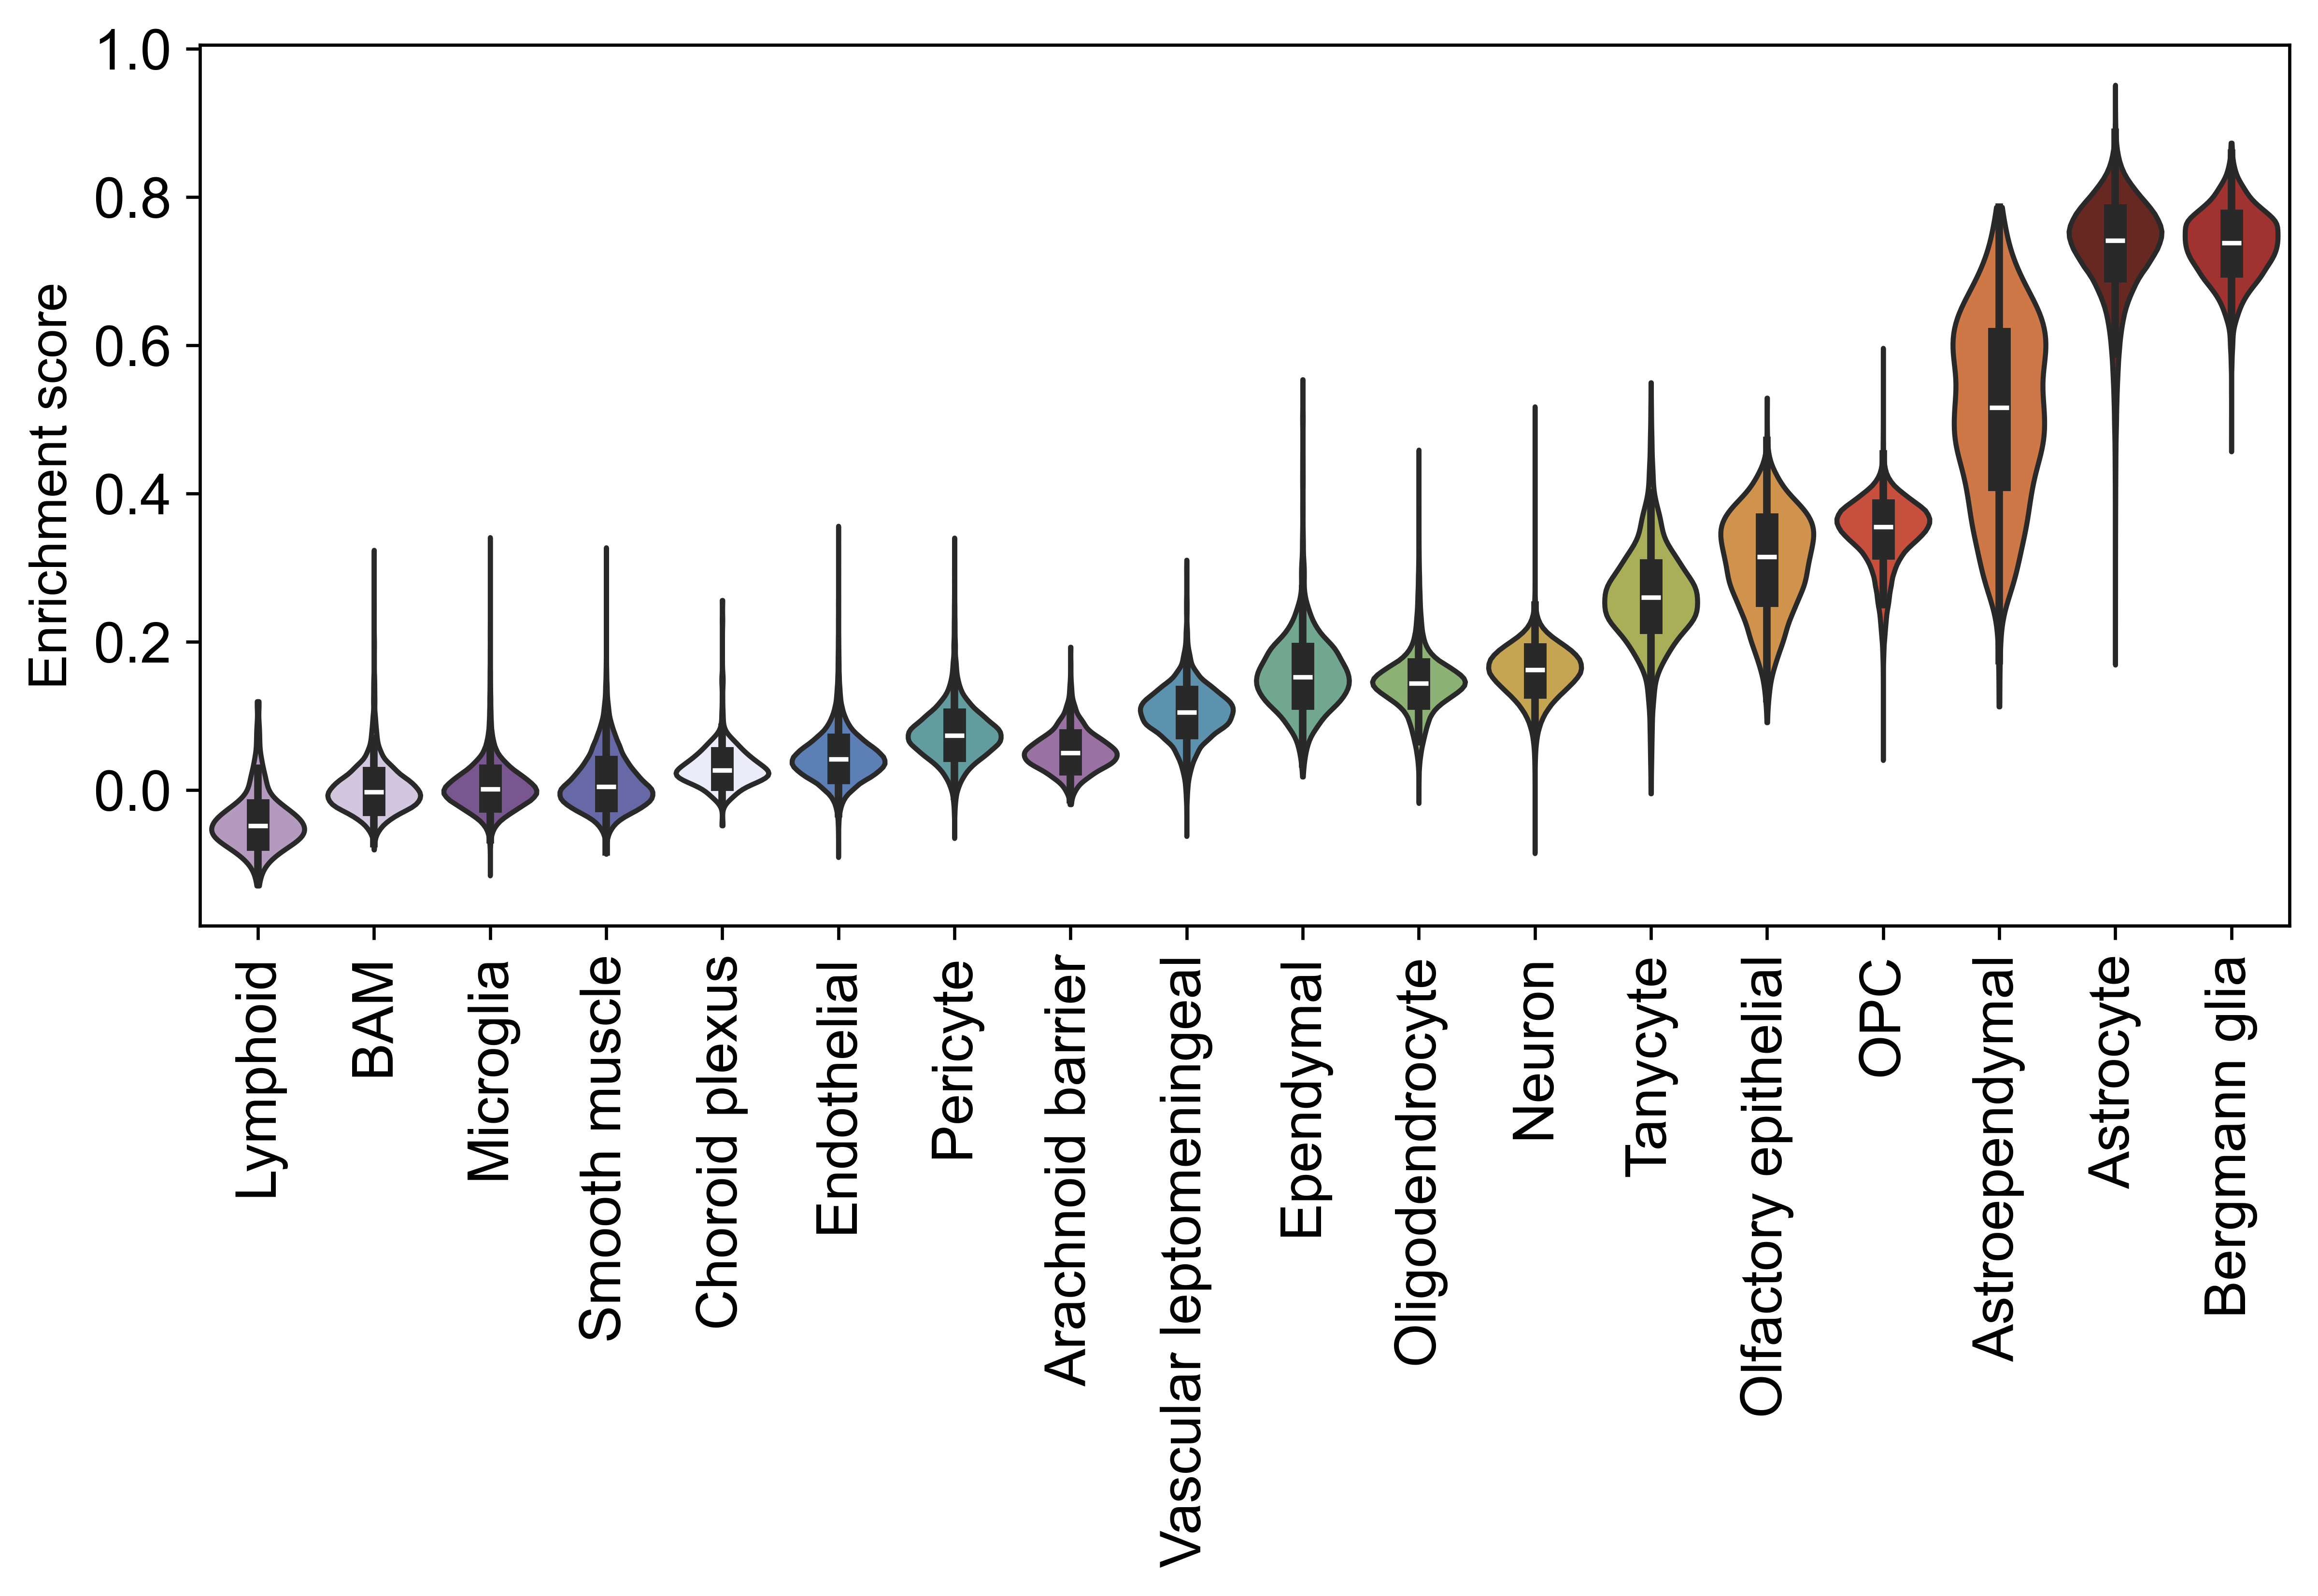

In [19]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    sc.pl.violin(mouse_atlas, keys=['Sig_Down_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box',
                order = ['Lymphoid', 'BAM', 'Microglia', 'Smooth muscle', 'Choroid plexus', 'Endothelial', 'Pericyte', 'Arachnoid barrier', 'Vascular leptomeningeal', 
                         'Ependymal', 'Oligodendrocyte', 'Neuron', 'Tanycyte', 'Olfactory epithelial', 'OPC', 'Astroependymal', 'Astrocyte', 'Bergmann glia'],
                palette = color_pal, show=False)
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/supplementaryfigure1a_downsignature.svg', format='svg', bbox_inches = 'tight')

In [20]:
cell_obs = mouse_atlas.obs
means = cell_obs.groupby('celltype')['Sig_Up_Signature'].mean()
means = means[sorted_names]
stds = cell_obs.groupby('celltype')['Sig_Up_Signature'].std()
stds = stds[sorted_names]
dmeans = cell_obs.groupby('celltype')['Sig_Down_Signature'].mean()
dmeans = dmeans[sorted_names]
dstds = cell_obs.groupby('celltype')['Sig_Down_Signature'].std()
dstds = dstds[sorted_names]
means_df = pd.DataFrame({'up':means, 'down':dmeans, 'upstd':stds, 'downstd':dstds, 'color':rainbow})

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/3138693309.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = cell_obs.groupby('celltype')['Sig_Up_Signature'].mean()
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/3138693309.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = cell_obs.groupby('celltype')['Sig_Up_Signature'].std()
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/3138693309.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/3258850030.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
/var/folders/s3/tntkzwtx595cbz0665j_z4tc0000gr/T/ipykernel_8617/3258850030.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.5)


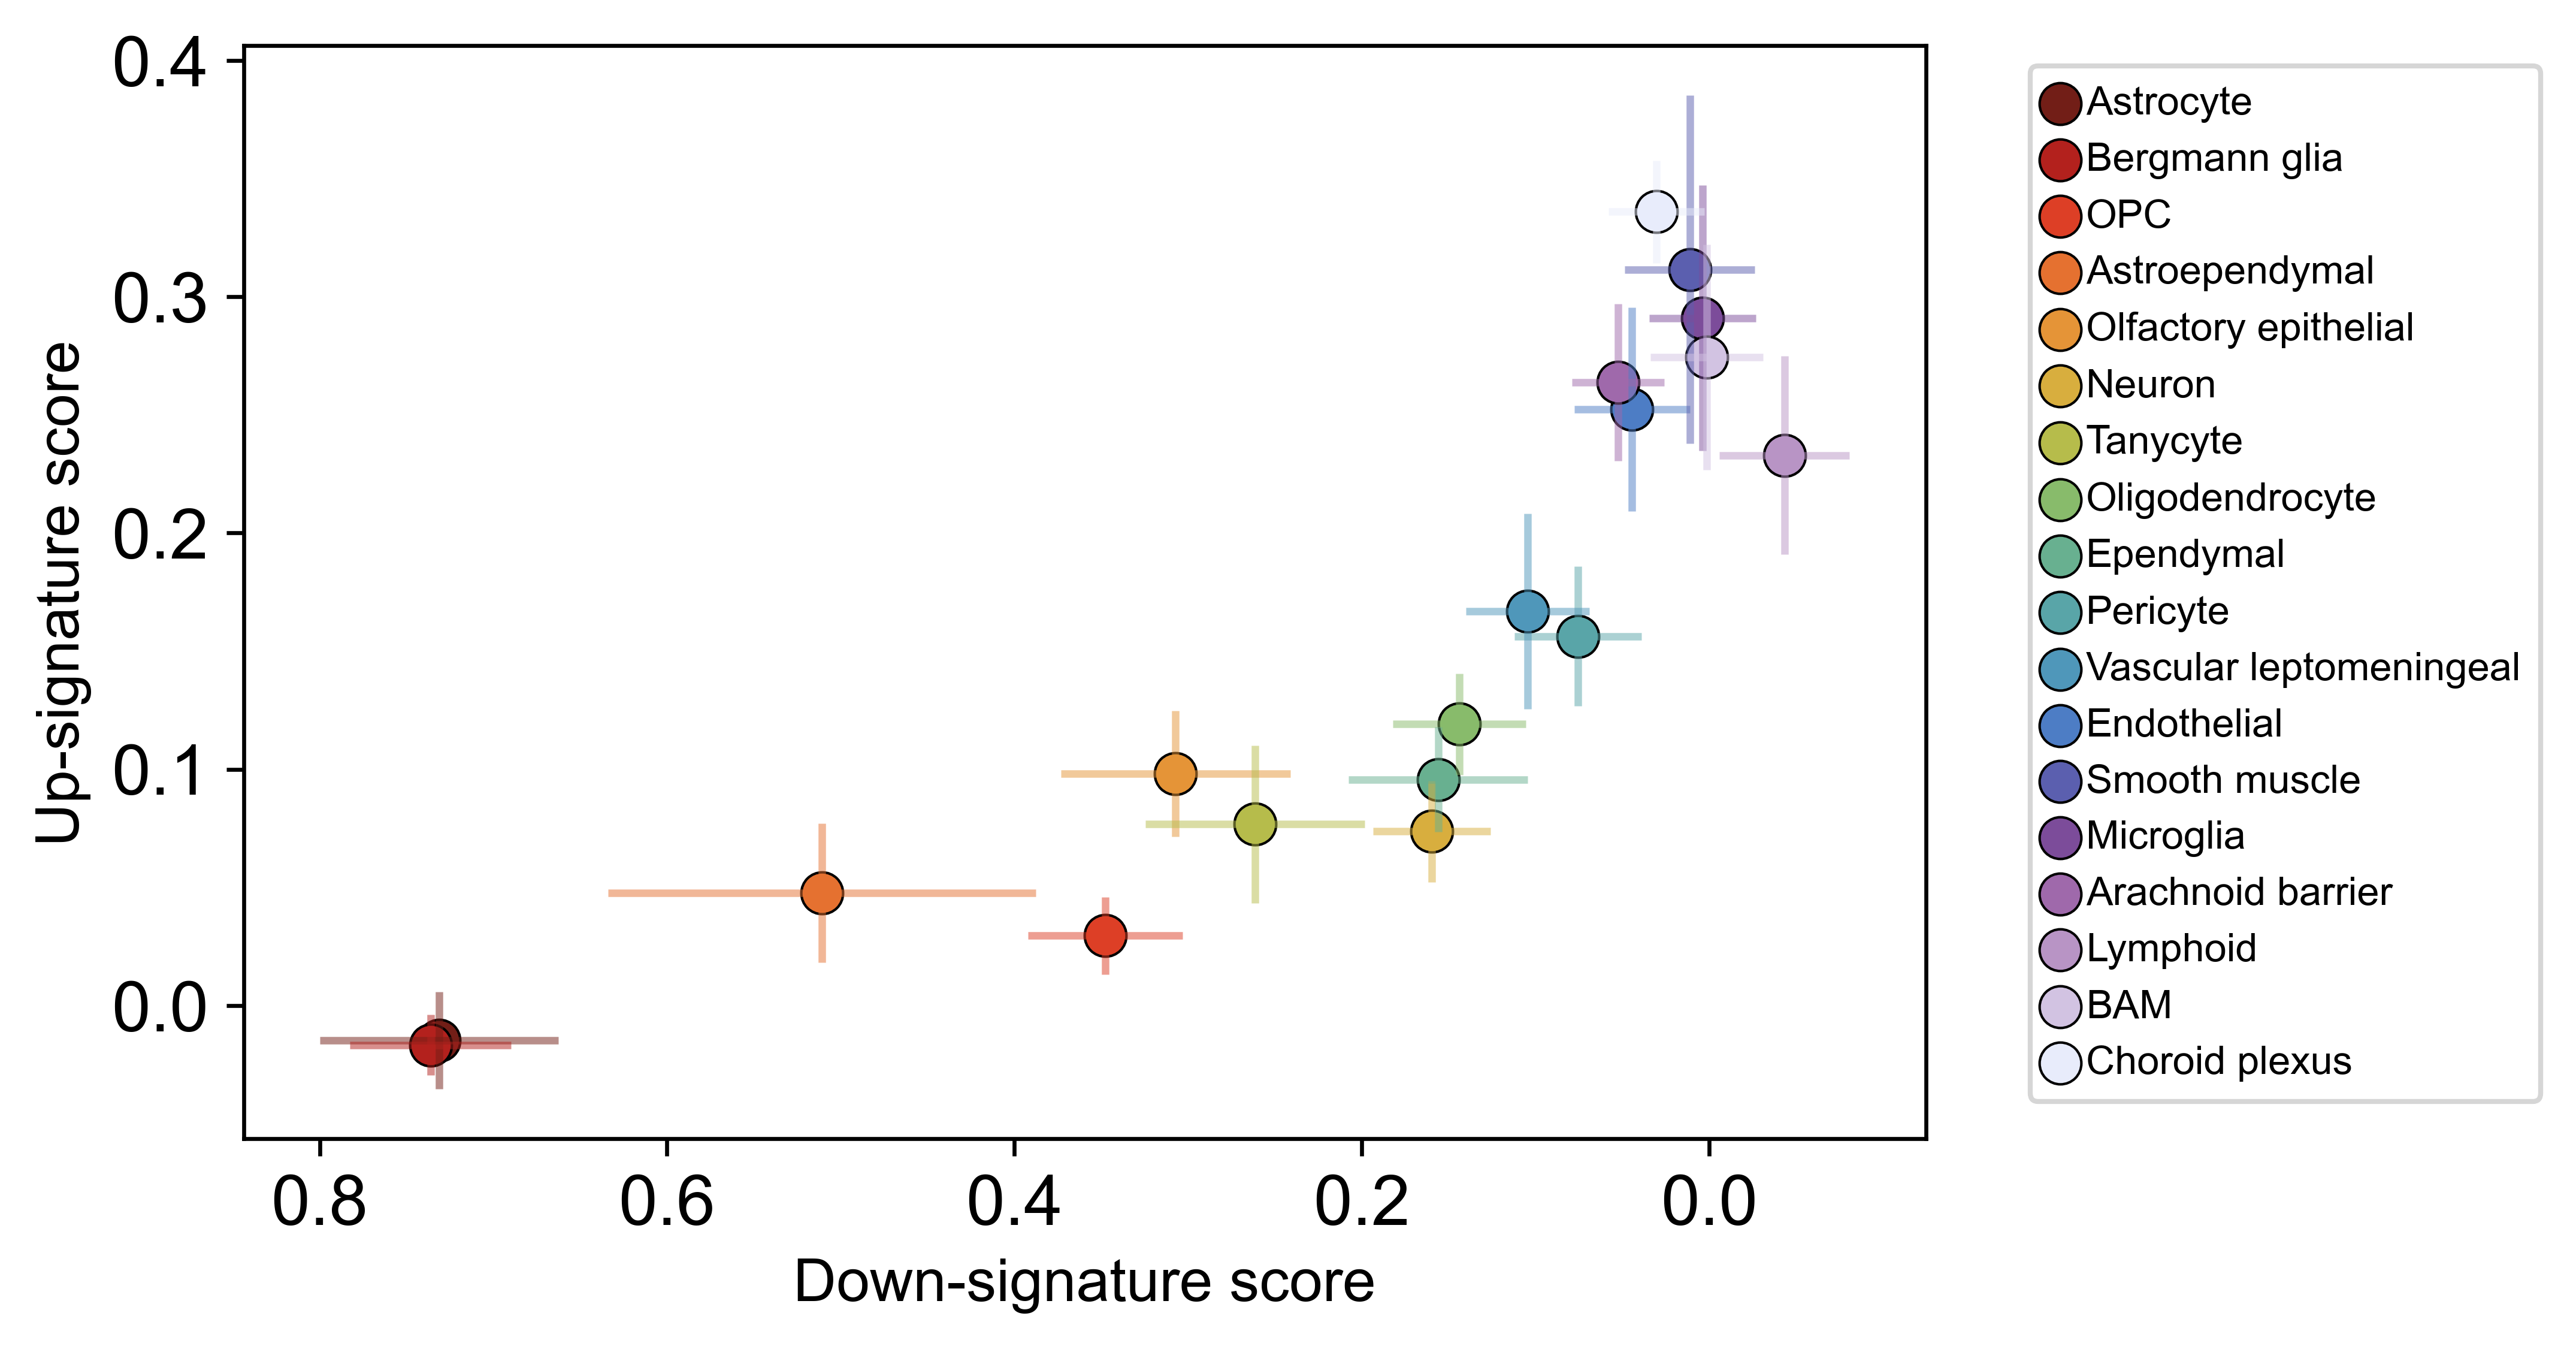

In [21]:
with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi":300}):
    fig, ax = plt.subplots()
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        ax.scatter(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], label = cluster, s = 70, edgecolor='black', linewidth=0.5, color = color)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, markerscale=1, borderpad=0.5)
    
    for cluster, color in zip(means_df.index.values, means_df['color'].values):
        idxs = np.where(means_df.index.values == cluster)
        plt.errorbar(x=means_df['down'][idxs[0]], y=means_df['up'][idxs[0]], xerr=means_df['downstd'][idxs[0]], yerr=means_df['upstd'][idxs[0]], color=color, alpha = 0.5)

    ax.invert_xaxis()
    plt.xlabel('Down-signature score', fontsize=12)
    plt.ylabel('Up-signature score', fontsize=12)
    plt.grid(False)
    plt.savefig('outputs/figures/supplementaryfigure1b.svg', format='svg', bbox_inches = 'tight')

Next, we'll evaluate the FIND-seq derived gene signature from Supplementary Table 9 in the same manner.

In [22]:
findseq = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM10_ESM.xlsx', header=None)
findseq = findseq[0].values
sc.tl.score_genes(mouse_atlas, gene_list=findseq, score_name="FINDseq_Signature")

       'Gm19220', 'Gm19327', 'Gm25190', 'Gm25197', 'Gm25735', 'Gm28017',
       'Gm37033', 'Gm37144', 'Gm37376', 'Gm38043', 'Gm38152', 'Gm38302',
       'Gm42535', 'Gm43321', 'Gm43540', 'Gm43652', 'Gm45223', 'Gm45799',
       'Gm47164', 'Gm47542', 'Gm47673', 'Gm48204', 'Gm48216', 'Gm48269',
       'Gm48271', 'Gm48309', 'Gm48600', 'Gm6899', 'Gm7968', 'mt-Rnr1',
       'mt-Rnr2', 'Rpl15-ps3', 'Rpl31-ps8', 'Rpl37rt', 'Rps12-ps3',
       'Rps23-ps1', 'Septin11', 'Ubb-ps'],
      dtype='object')


/Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


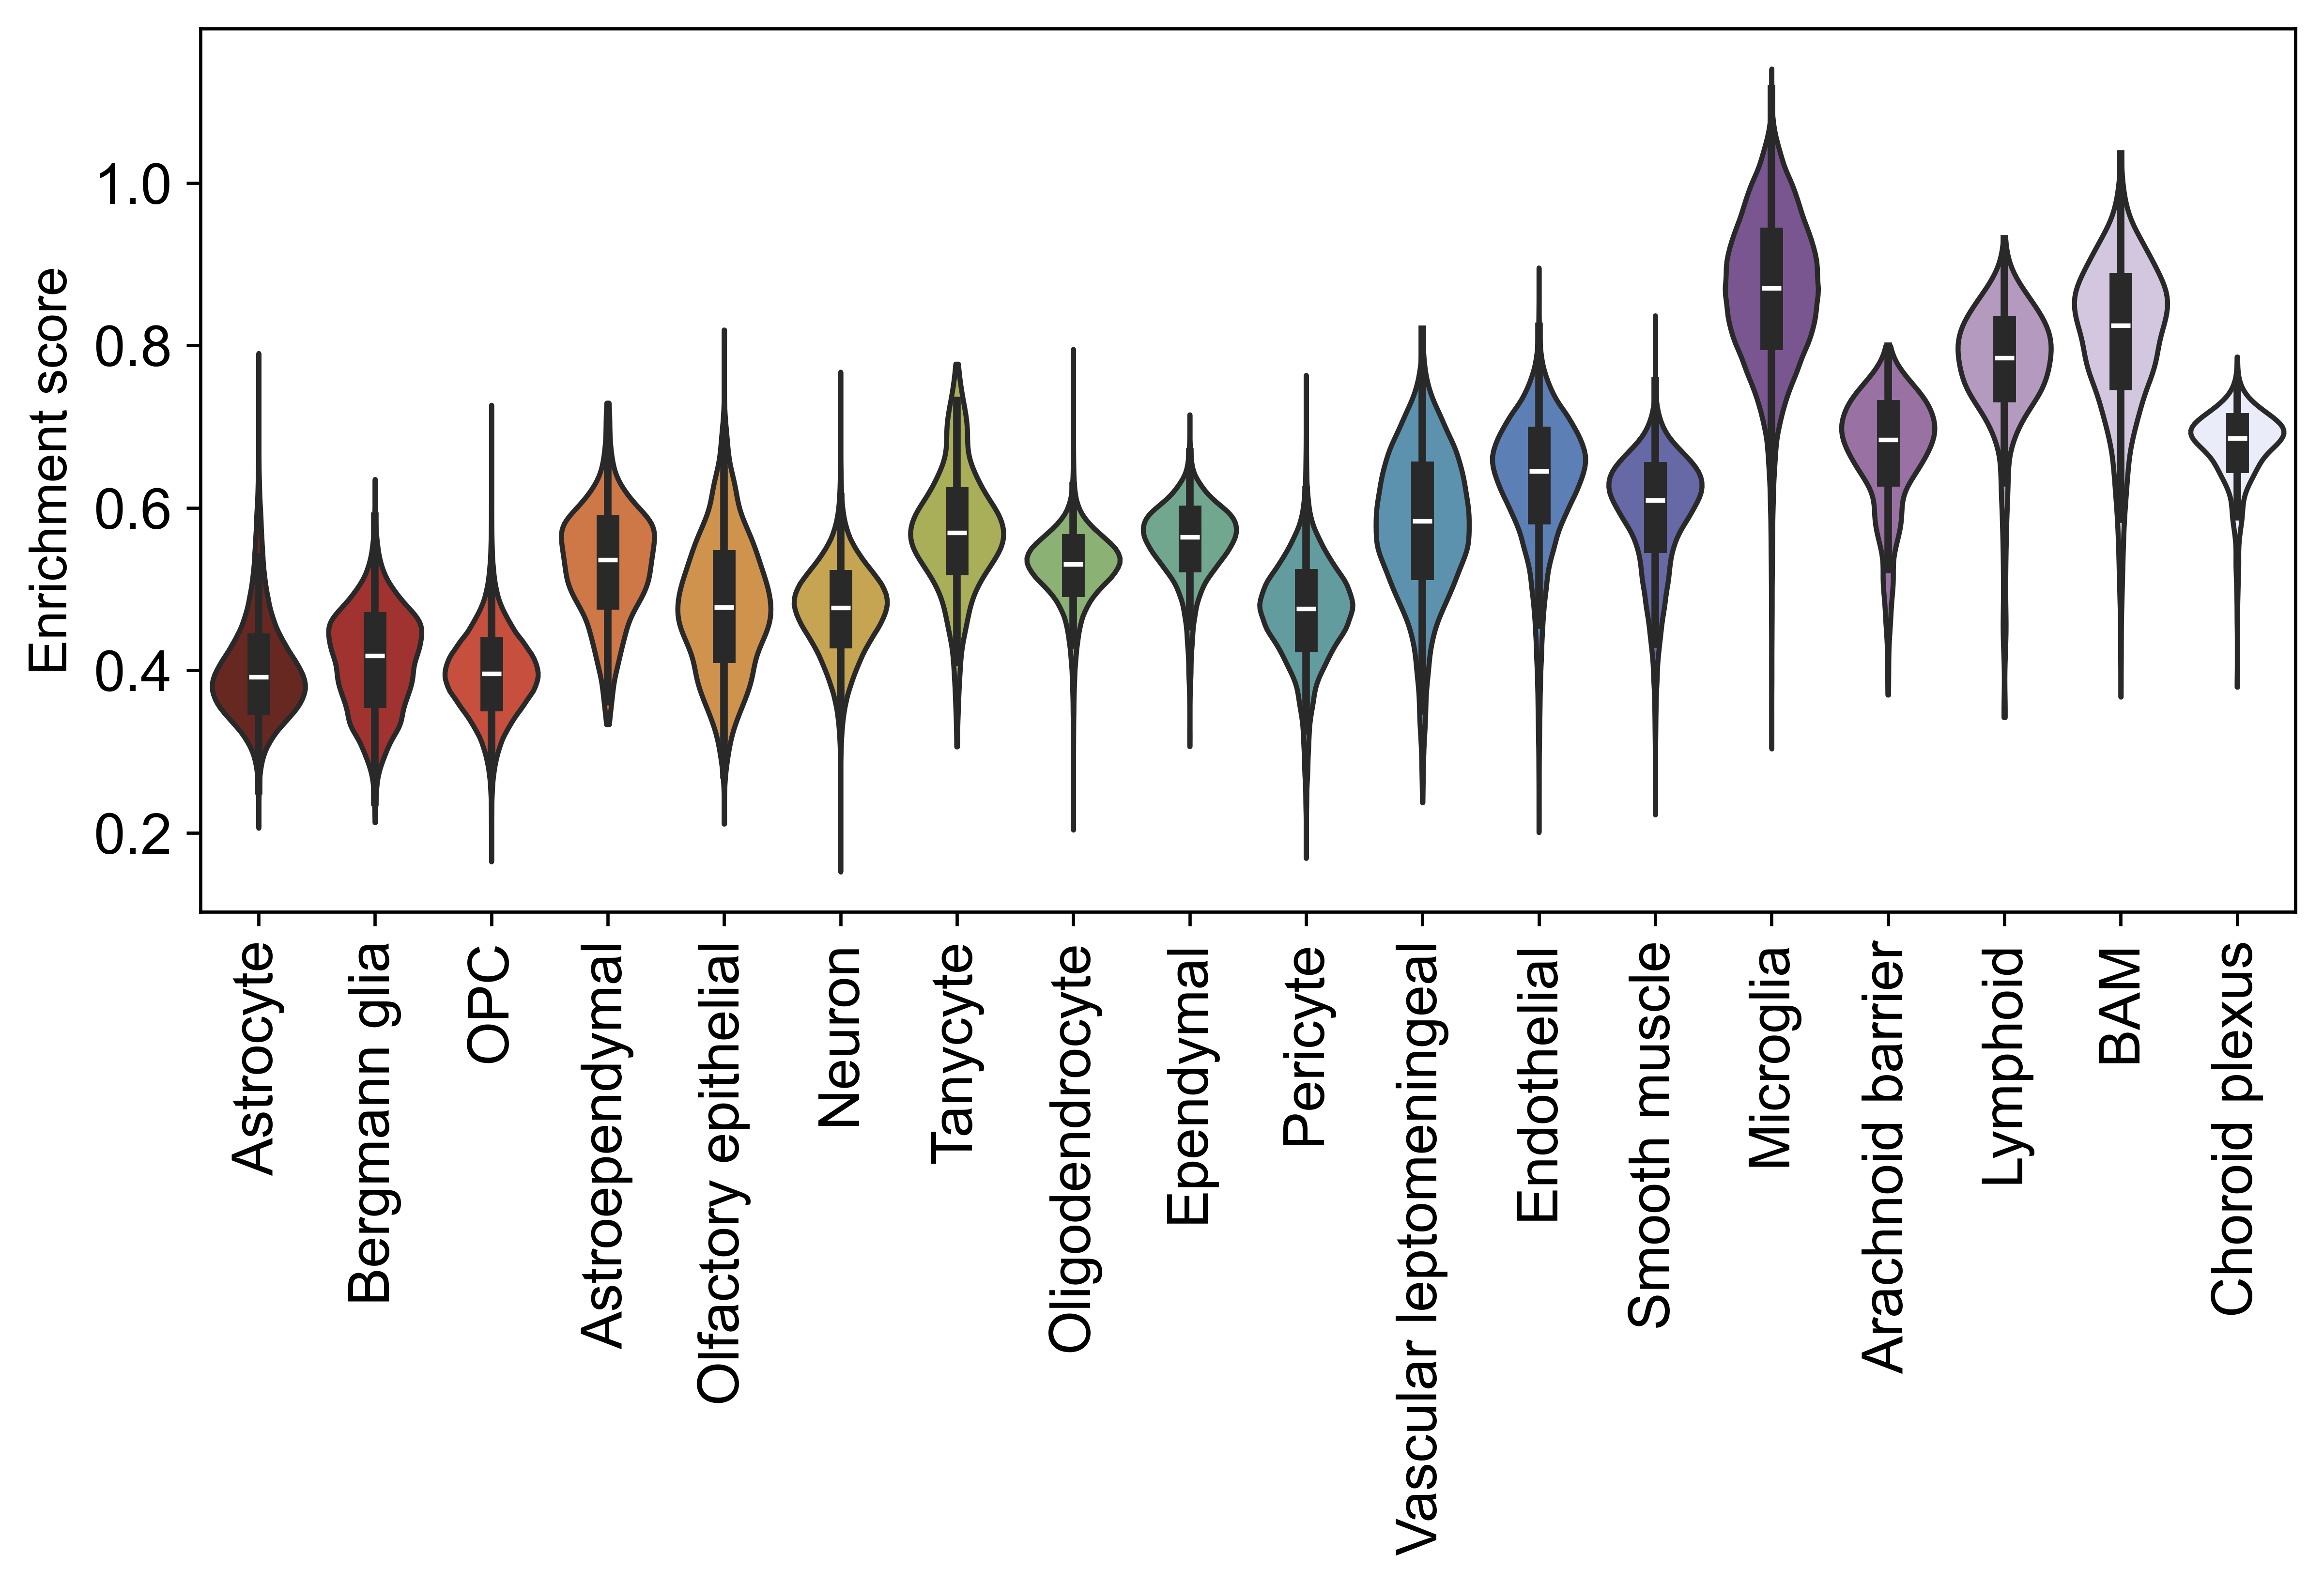

In [23]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":300}):
    ax = sc.pl.violin(mouse_atlas, keys=['FINDseq_Signature'], groupby="celltype", rotation=90, stripplot = False, inner = 'box', 
                order = ['Astrocyte', 'Bergmann glia', 'OPC', 'Astroependymal', 'Olfactory epithelial', 'Neuron', 'Tanycyte', 'Oligodendrocyte', 'Ependymal', 'Pericyte', 'Vascular leptomeningeal', 
                        'Endothelial', 'Smooth muscle', 'Microglia', 'Arachnoid barrier', 'Lymphoid', 'BAM', 'Choroid plexus'],
                palette = color_pal, show=False)
    plt.ylabel('Enrichment score', fontsize = 13)
    plt.grid(False)
    plt.savefig('outputs/figures/supplementaryfigure1c_findseq.svg', format='svg', bbox_inches = 'tight')

Now we'll extract matrices containing the average normalized expression within each cell type class for the up-signature genes and down-signature genes, and save these as CSV files. We'll use these for plotting heatmaps in Step 4.

In [24]:
avg_ad = sc.get.aggregate(mouse_atlas, by = "celltype", func="mean")
avg_exp = pd.DataFrame(avg_ad.layers['mean'].T, index = avg_ad.var_names, columns = avg_ad.obs_names)

up_signature_avg_exp = avg_exp[avg_exp.index.isin(up_signature)]
up_signature_avg_exp.to_csv("outputs/mouse_atlas_up_signature_avg_expression_dataframe.csv")

down_signature_avg_exp = avg_exp[avg_exp.index.isin(down_signature)]
down_signature_avg_exp.to_csv("outputs/mouse_atlas_down_signature_avg_expression_dataframe.csv")

Lastly, we'll evaluate expression of Ep300 and Acly across all the cell type groups.

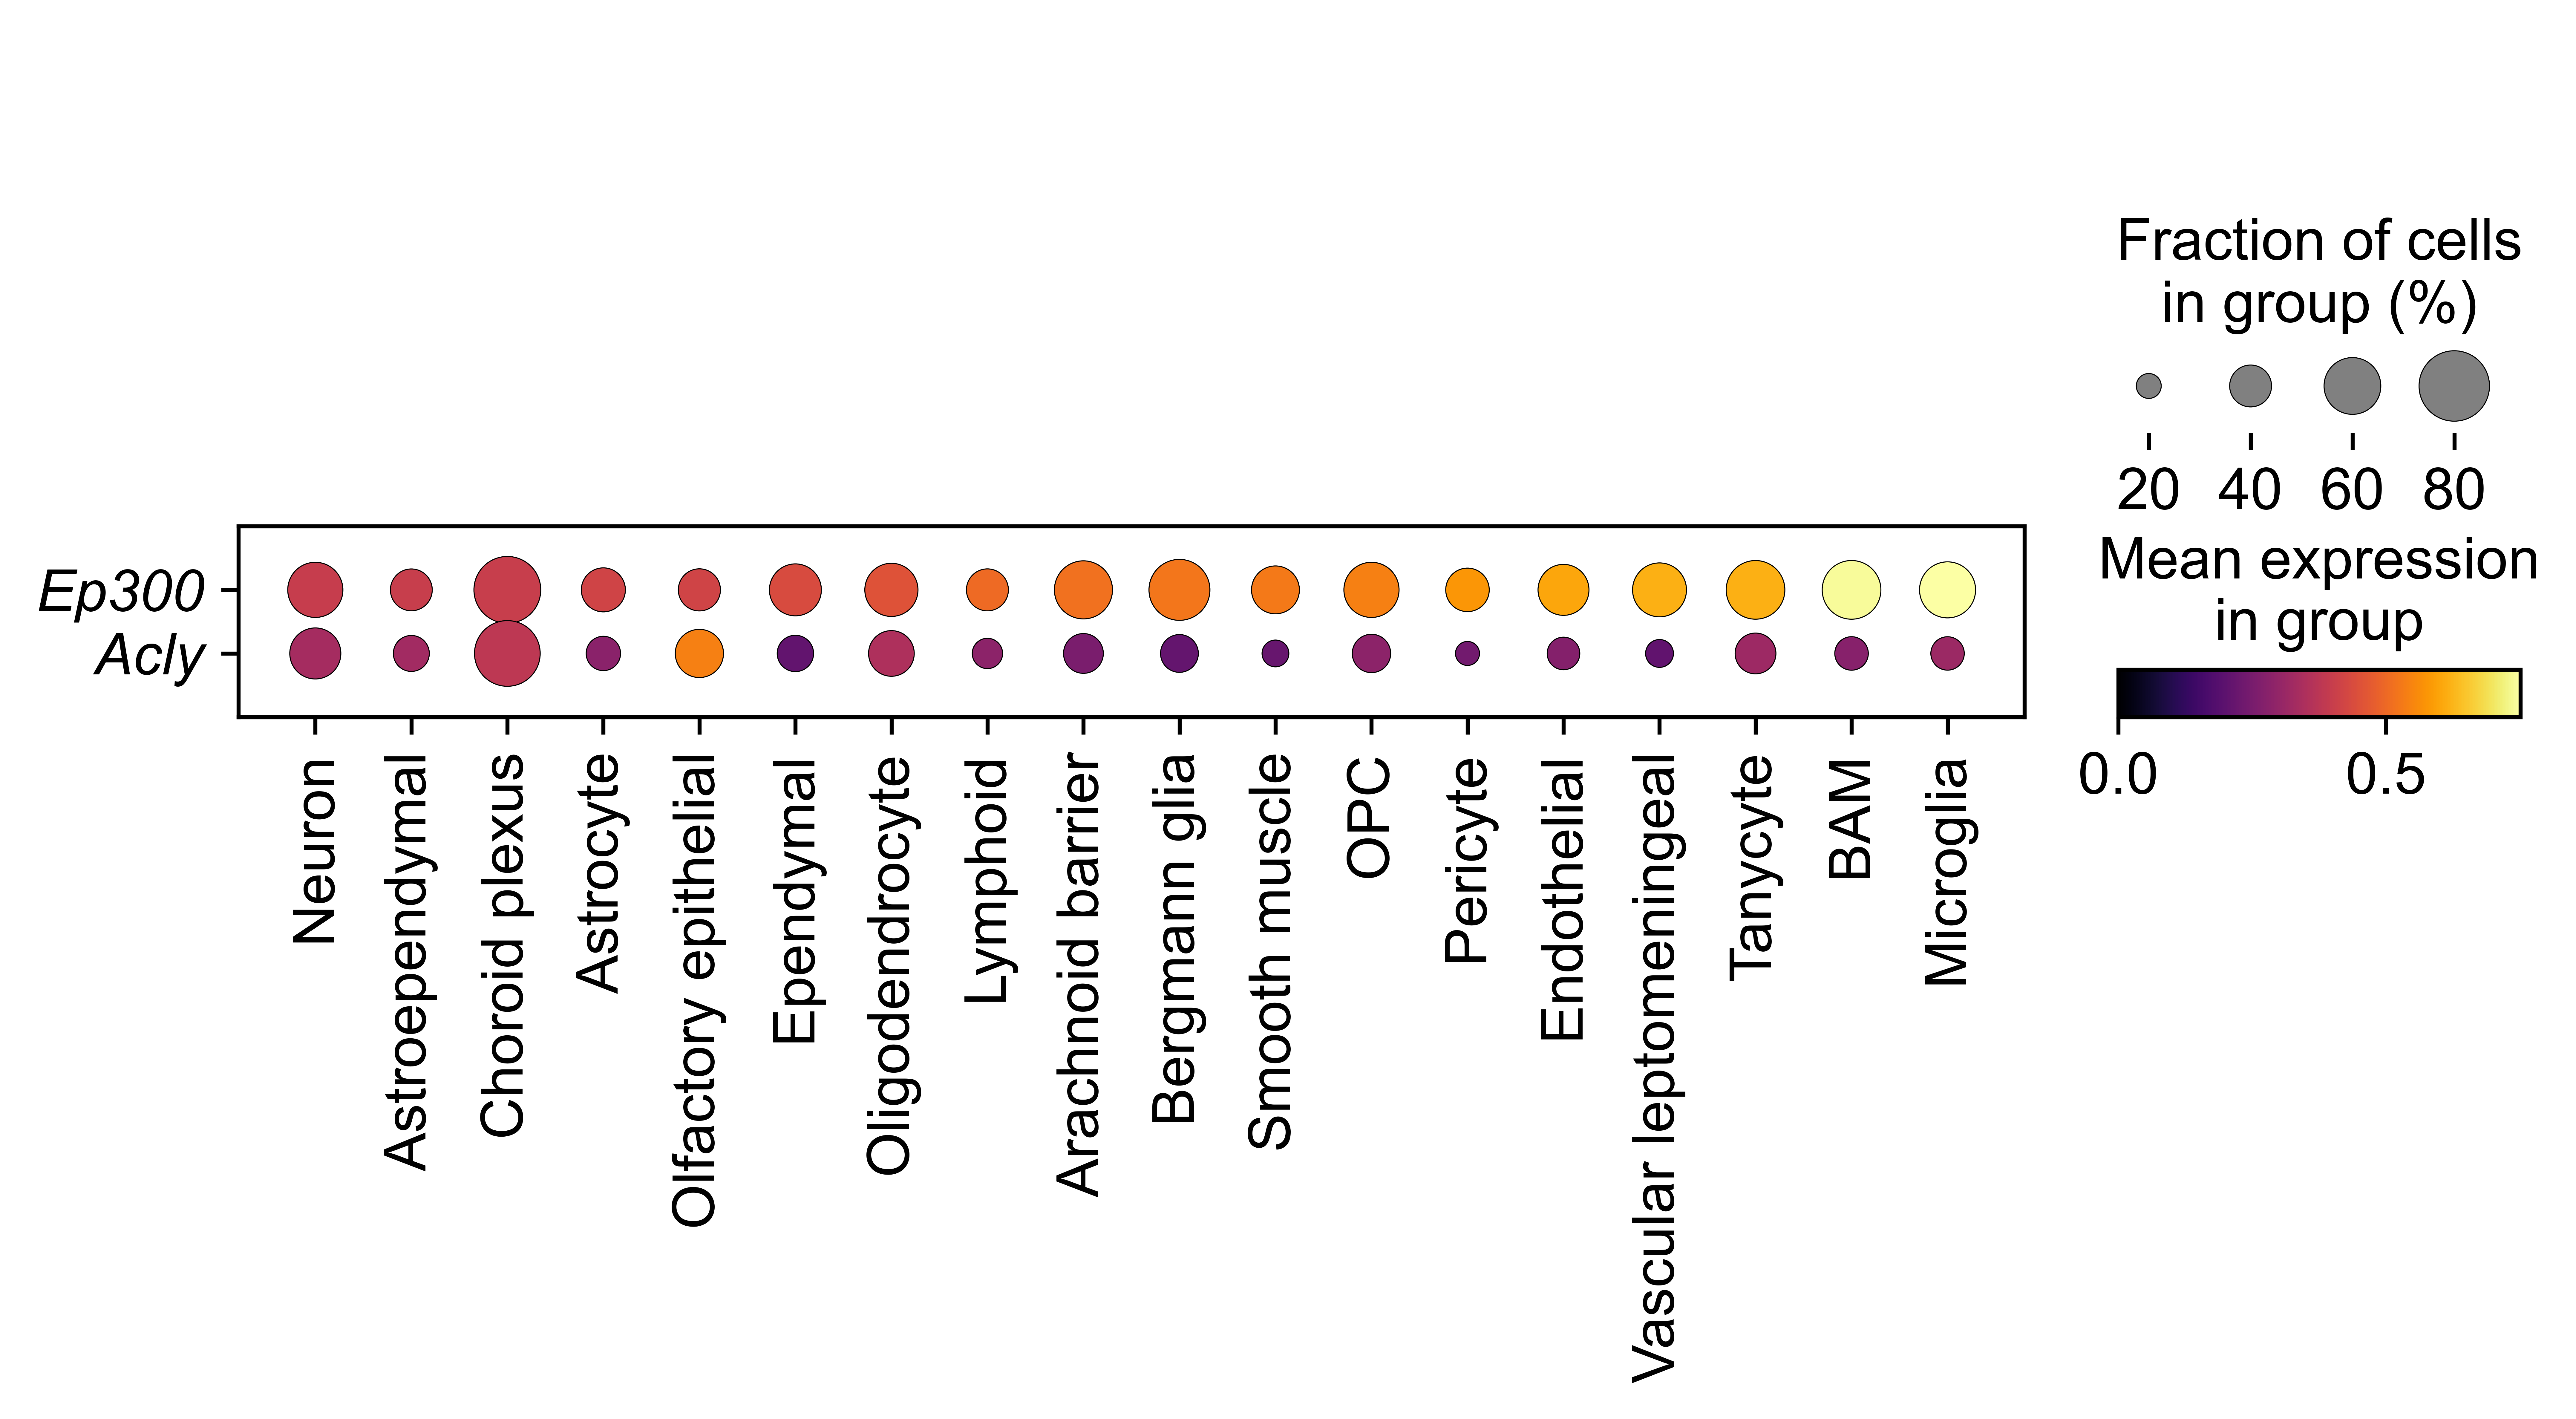

In [25]:
with plt.rc_context({"figure.figsize": (8, 4), "figure.dpi":600}):
    cat_order = avg_exp[avg_exp.index == 'Ep300'].transpose().sort_values(by = "Ep300").index.values
    
    dp = sc.pl.dotplot(mouse_atlas, var_names=['Ep300', 'Acly'], groupby="celltype", swap_axes = True, vmin = 0, cmap = "inferno",
             categories_order = cat_order, show = False)

    ax = dp['mainplot_ax']
    for l in ax.get_yticklabels():
        l.set_style('italic')
    
    fig = plt.gcf()
    cbar_ax = fig.axes[-1]
    cbar_ax.grid(False)
    
    plt.savefig('outputs/figures/figure2h.svg', format='svg', bbox_inches = 'tight')
    plt.show()